In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-data/__results__.html
/kaggle/input/final-data/__notebook__.ipynb
/kaggle/input/final-data/__output__.json
/kaggle/input/final-data/custom.css
/kaggle/input/final-data/phase2/user_train_phase_2_test.csv
/kaggle/input/final-data/phase2/user_train_phase_2.csv
/kaggle/input/final-data/phase2/user_train_phase_2_train.csv
/kaggle/input/final-data/__results___files/__results___72_0.png
/kaggle/input/final-data/__results___files/__results___67_0.png
/kaggle/input/final-data/__results___files/__results___60_0.png
/kaggle/input/final-data/__results___files/__results___77_1.png
/kaggle/input/final-data/__results___files/__results___145_0.png
/kaggle/input/final-data/__results___files/__results___70_0.png
/kaggle/input/final-data/__results___files/__results___63_0.png
/kaggle/input/final-data/__results___files/__results___78_1.png
/kaggle/input/final-data/__results___files/__results___58_0.png
/kaggle/input/final-data/__results___files/__results___178_0.png
/kaggle/input/final

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (f1_score, precision_score, recall_score, accuracy_score, 
                             roc_auc_score, roc_curve, confusion_matrix)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV  
from eli5.sklearn import PermutationImportance  

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, roc_curve
)

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

2025-05-05 13:13:56.928479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746450837.151112      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746450837.210968      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Load dữ liệu

In [3]:
def load_data(phase):
    # Đọc dữ liệu từ các file CSV
    phase_ = phase[:-1] + '_' + phase[-1]
    X_train = pd.read_csv(f"/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv")
    X_test = pd.read_csv(f"/kaggle/input/final-data/{phase}/user_train_{phase_}_test.csv")
    
    # In thông tin chung về dữ liệu
    print(X_train.info())

    count_map = X_train['school'].value_counts().to_dict()
    X_train['school'] = X_train['school'].map(count_map)
    X_test['school'] = X_test['school'].map(count_map)

    # Fill nan = 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    # Loại bỏ các cột không cần thiết trong X
    columns_to_drop = ['course_id', 'user_id', 'total_score', 'label']
    X_train = X_train.drop(columns=columns_to_drop, axis=1)
    X_test = X_test.drop(columns=columns_to_drop, axis=1)
    
    # Lấy nhãn (target) từ cột 'label_encoded'
    y_train = X_train.pop("label_encoded")
    y_test = X_test.pop("label_encoded")
    
    return X_train, y_train, X_test, y_test

# 2. Đánh giá dữ liệu

In [4]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    def evaluate_split(X, y, split_name=""):
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)

        f1 = f1_score(y, y_pred, average=None)
        precision = precision_score(y, y_pred, average=None)
        recall = recall_score(y, y_pred, average=None)
        accuracy = accuracy_score(y, y_pred)

        # Binarize labels for AUC
        y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4])
        auc = roc_auc_score(y_bin, y_proba, multi_class="ovr")

        print(f"\n====== {split_name} Set ======")
        print("F1 Score (per class):", f1)
        print("Precision (per class):", precision)
        print("Recall (per class):", recall)
        print(f"Accuracy: {accuracy}")
        print(f"AUC (One-vs-Rest): {auc}")

        return {
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'auc': auc,
            'y_true': y,
            'y_pred': y_pred,
            'y_proba': y_proba
        }

    # Đánh giá train
    train_results = evaluate_split(X_train, y_train, "Train")

    # Đánh giá test
    test_results = evaluate_split(X_test, y_test, "Test")

    # Vẽ confusion matrix cho test
    conf_matrix = confusion_matrix(test_results['y_true'], test_results['y_pred'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["E", "D", "C", "B", "A"],
                yticklabels=["A", "B", "C", "D", "E"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Vẽ ROC curve cho từng lớp (test set)
    plt.figure(figsize=(10, 8))
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    for i in range(5):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_results['y_proba'][:, i])
        auc = roc_auc_score(y_test_bin[:, i], test_results['y_proba'][:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend(loc='best')
    plt.show()

    return {
        'train': train_results,
        'test': test_results
    }

# 3. Scale dữ liệu

In [5]:
# Áp dụng các kỹ thuật Scaling
def scale_data(X_train, X_test, scaler_type):
    # Khởi tạo bộ scaler phù hợp với loại được chọn
    if scaler_type == "minmax":
        scaler = MinMaxScaler()
    elif scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "robust":
        scaler = RobustScaler()
    elif scaler_type == "log":
        # Thực hiện log scaling, cộng thêm một giá trị nhỏ để tránh log(0)
        if (X_train <= 0).values.any():
            X_train = X_train + 1 - X_train.min()  # Điều chỉnh để tất cả giá trị > 0
        X_train = np.log(X_train)  # Áp dụng log cho dữ liệu
        X_test = np.log(X_test + 1 - X_test.min())  # Áp dụng log cho dữ liệu test
        return X_train, X_test
    else:
        raise ValueError("Scaler type not recognized")
    
    # Fit bộ scaler trên dữ liệu huấn luyện và transform dữ liệu huấn luyện và kiểm tra
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Transform dữ liệu test bằng scaler đã fit trên train
    
    return X_train_scaled, X_test_scaled

# 4. Permutation importance

In [6]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X_train, y_train):
    result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": result.importances_mean
    }).sort_values(by="Importance", ascending=False)
    
    # Vẽ biểu đồ Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title("Feature Importance (Permutation Importance)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    return importance_df

# Lasso

In [7]:
def lasso_feature_selection(X_train, y_train):
    from sklearn.linear_model import LassoCV

    # Lasso Regression với Cross-Validation
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
    lasso.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(lasso.coef_)
    }).sort_values(by='Importance', ascending=False)
    
    # Vẽ biểu đồ trọng số
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title("Feature Importance (Lasso Regression)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    selected_features = feature_importance[feature_importance['Importance'] > 0]['Feature'].tolist()

    return selected_features, feature_importance

# Boruta Truck

In [8]:
def boruta_trick(model, X_train, y_train):
    # Tạo một feature ngẫu nhiên (feature "ngẫu nhiên")
    random_feature = np.random.rand(X_train.shape[0], 1)
    X_train_random = np.hstack([X_train.values, random_feature])

    # Huấn luyện mô hình Random Forest
    model.fit(X_train_random, y_train)

    # Tính toán importance của từng feature
    feature_importance = pd.DataFrame({
        'Feature': list(X_train.columns) + ['Random Feature'],
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Lọc các feature quan trọng hơn feature ngẫu nhiên
    important_features = feature_importance[feature_importance['Importance'] > feature_importance['Importance'].iloc[-1]]
    print('important feature: ', important_features)
    # Vẽ biểu đồ importance
    feature_importance.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(8, 6))
    plt.title("Boruta Feature Importance (Trick)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    return important_features

# Calibration

In [9]:
def calibrate_model(model, X_train, y_train, method='sigmoid'):
    """
    Áp dụng Calibration cho mô hình phân loại (hỗ trợ CatBoost và các mô hình khác).
    
    Parameters:
    - model: Mô hình đã huấn luyện
    - X_train: Dữ liệu huấn luyện
    - y_train: Nhãn huấn luyện
    - method: Phương pháp calibration ('sigmoid' hoặc 'isotonic')
    
    Returns:
    - calibrated_model: Mô hình đã được calibrate
    """
    # Nếu là CatBoost, thông báo nhẹ
    if isinstance(model, CatBoostClassifier):
        print("[Warning] CatBoostClassifier đã hỗ trợ predict_proba tốt. Calibration có thể không cần thiết.")
    
    # Calibration
    calibrated_model = CalibratedClassifierCV(base_estimator=model, method=method, cv=5)
    calibrated_model.fit(X_train, y_train)
    
    return calibrated_model

# 1.Standard

In [12]:
from sklearn.neighbors import KNeighborsClassifier

def process_phase(phase, scale='standard', metric='accuracy'):
    # Đọc dữ liệu
    X_train, y_train, X_test, y_test = load_data(phase)

    # Scale dữ liệu
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaler_type=scale)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Thiết lập StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Định nghĩa mô hình KNN
    model = KNeighborsClassifier()

    # Tham số tìm kiếm cho KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=skf,
        scoring=metric,
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    # Huấn luyện mô hình
    randomized_search.fit(X_train_scaled, y_train)

    # In tham số tốt nhất
    best_params = randomized_search.best_params_
    print(f"\n=== Best Parameters for phase {phase}: {best_params} ===")

    # Đánh giá mô hình gốc
    print(f"\n=== Evaluation for phase {phase} ===")
    evaluation_results = evaluate_model(
        randomized_search.best_estimator_,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # Lấy các kết quả từ evaluation_results
    train_results = evaluation_results['train']
    test_results = evaluation_results['test']

    # In kết quả
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()}: {train_results[metric_name]} | Test {metric_name.capitalize()}: {test_results[metric_name]}")

    # Lưu kết quả dự đoán
    y_pred = randomized_search.best_estimator_.predict(X_test_scaled)
    results_df = X_test.copy()
    results_df['True_Label'] = y_test
    results_df['Predicted_Label'] = y_pred
    results_filename = f"test_results_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"Test predictions saved as {results_filename}")

    # Calibrate model (sử dụng Platt scaling với KNN)
    calibrate_train_model = calibrate_model(randomized_search.best_estimator_, X_train_scaled, y_train)

    # Đánh giá mô hình sau calibrate
    print(f"\n=== Evaluation after calibration for phase {phase} ===")
    evaluation_results_cal = evaluate_model(
        calibrate_train_model,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # In kết quả sau hiệu chuẩn
    train_results_cal = evaluation_results_cal['train']
    test_results_cal = evaluation_results_cal['test']
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()} (calibrated): {train_results_cal[metric_name]} | Test {metric_name.capitalize()} (calibrated): {test_results_cal[metric_name]}")

    # Lưu kết quả dự đoán sau calibrate
    y_calibrate_pred = calibrate_train_model.predict(X_test_scaled)
    results_df['Calibrated_Predicted_Label'] = y_calibrate_pred
    results_calibrate_filename = f"test_results_calibrate_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_calibrate_filename, index=False)
    print(f"Calibrated predictions saved as {results_calibrate_filename}")

    # Nếu phase 1 hoặc 2 → chạy chọn feature
    if int(phase[-1]) <= 2:
        print(f"\n=== Permutation Importance for phase {phase} ===")
        perm_importance = plot_permutation_importance(randomized_search.best_estimator_, X_train_scaled, y_train)

        print(f"\n=== Lasso Feature Selection for phase {phase} ===")
        lasso_importance = lasso_feature_selection(X_train_scaled, y_train)

        # model_with_best_params = KNeighborsClassifier(**best_params)
        # print("\n=== Boruta Trick ===")
        # important_features = boruta_trick(model_with_best_params, X_train_scaled, y_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   user_id                              10570 non-null  object 
 1   school                               6715 non-null   object 
 2   course_id                            10570 non-null  object 
 3   field_encoded_1                      10570 non-null  int64  
 4   field_encoded_2                      10570 non-null  int64  
 5   start_year                           10570 non-null  float64
 6   start_month                          10570 non-null  float64
 7   end_year                             10570 non-null  float64
 8   end_month                            10570 non-null  float64
 9   user_year                            10570 non-null  float64
 10  user_month                           10570 non-null  float64
 11  video_count                 

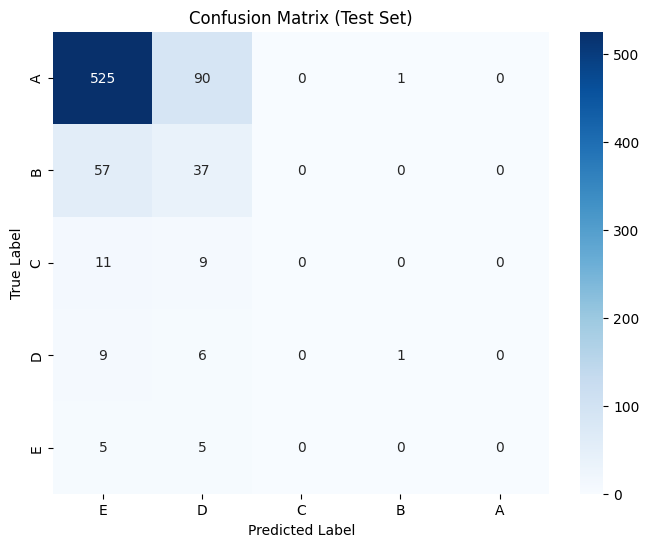

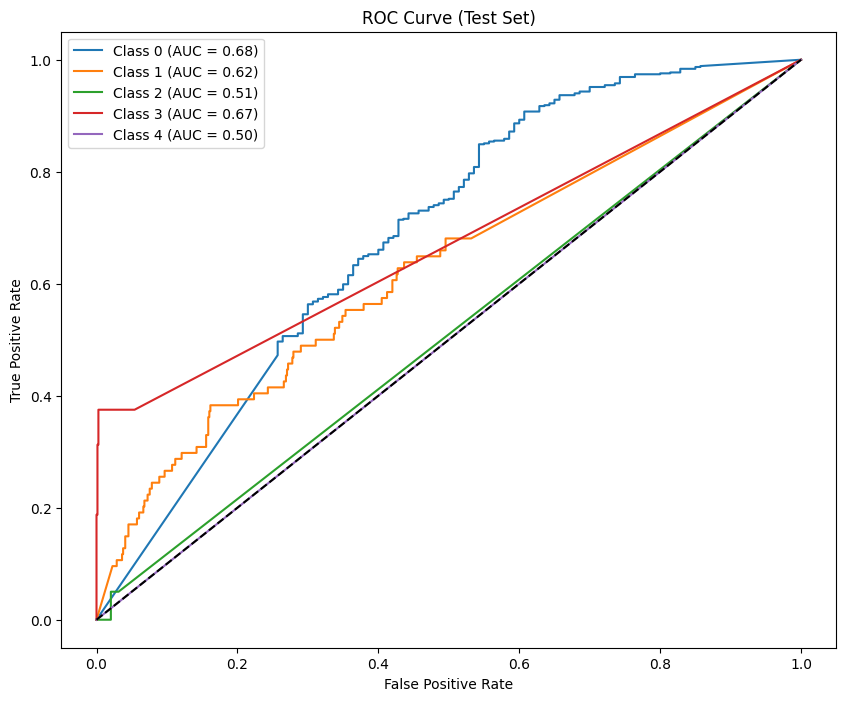

Train F1: [0.88441793 0.72639559 0.59259259 0.59649123 0.6557377 ] | Test F1: [0.85854456 0.30705394 0.         0.11111111 0.        ]
Train Precision: [0.85534085 0.76794171 0.88888889 0.66666667 0.58823529] | Test Precision: [0.86490939 0.25170068 0.         0.5        0.        ]
Train Recall: [0.91554151 0.68911409 0.44444444 0.53968254 0.74074074] | Test Recall: [0.85227273 0.39361702 0.         0.0625     0.        ]
Train Accuracy: 0.8285714285714286 | Test Accuracy: 0.7447089947089947
Train Auc: 0.9333941309017139 | Test Auc: 0.597219335324911
Test predictions saved as test_results_standard_f1_macro_phase1.csv

=== Evaluation after calibration for phase phase1 ===

====== Train Set ======
F1 Score (per class): [0.86302563 0.63017948 0.         0.         0.13793103]
Precision (per class): [0.76113671 0.97799175 0.         0.         1.        ]
Recall (per class): [0.99640908 0.4648578  0.         0.         0.07407407]
Accuracy: 0.7910122989593188
AUC (One-vs-Rest): 0.94942464

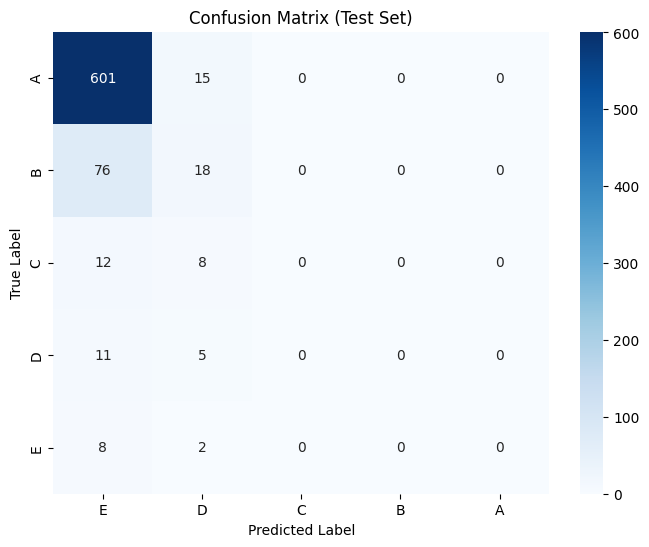

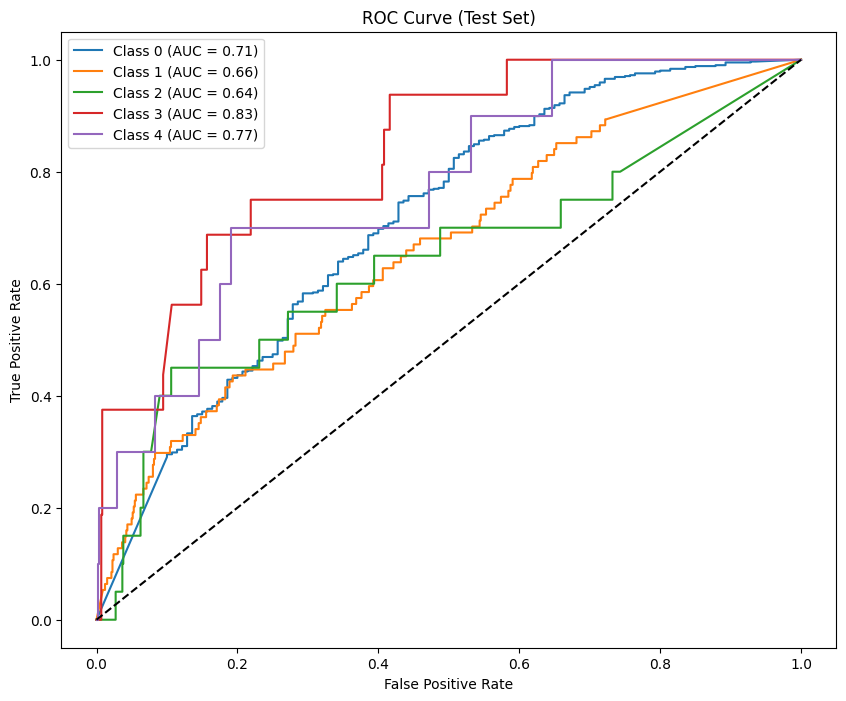

Train F1 (calibrated): [0.86302563 0.63017948 0.         0.         0.13793103] | Test F1 (calibrated): [0.90785498 0.25352113 0.         0.         0.        ]
Train Precision (calibrated): [0.76113671 0.97799175 0.         0.         1.        ] | Test Precision (calibrated): [0.84887006 0.375      0.         0.         0.        ]
Train Recall (calibrated): [0.99640908 0.4648578  0.         0.         0.07407407] | Test Recall (calibrated): [0.97564935 0.19148936 0.         0.         0.        ]
Train Accuracy (calibrated): 0.7910122989593188 | Test Accuracy (calibrated): 0.8187830687830688
Train Auc (calibrated): 0.9494246455025394 | Test Auc (calibrated): 0.7230822116306761
Calibrated predictions saved as test_results_calibrate_standard_f1_macro_phase1.csv

=== Permutation Importance for phase phase1 ===


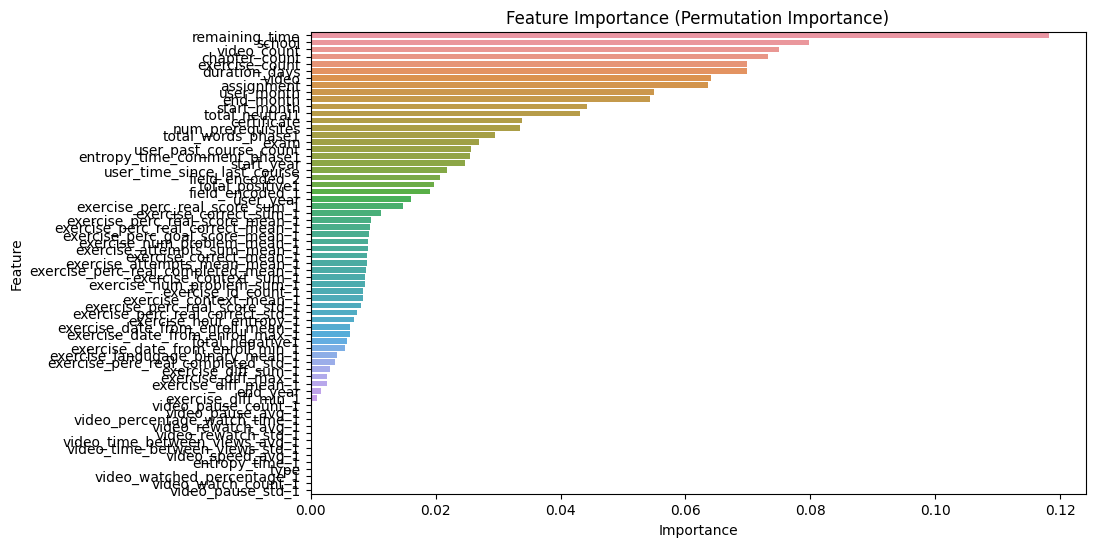


=== Lasso Feature Selection for phase phase1 ===


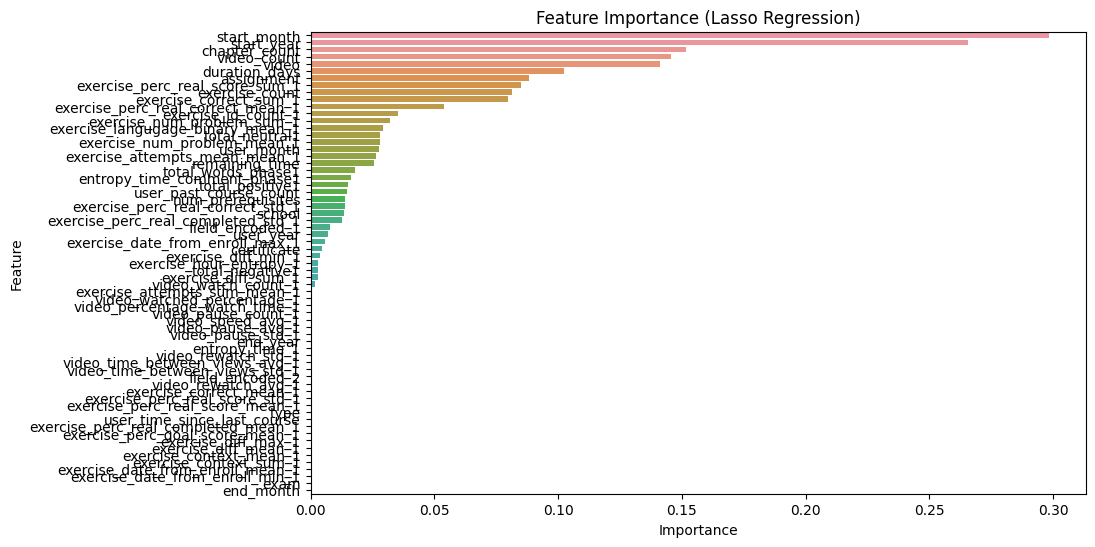

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Columns: 113 entries, user_id to label_encoded
dtypes: float64(100), int64(9), object(4)
memory usage: 7.4+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Parameters for phase phase2: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'} ===

=== Evaluation for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.87986957 0.70439704 0.56763926 0.59854015 0.73333333]
Precision (per class): [0.84968512 0.75220828 0.72789116 0.67955801 0.62857143]
Recall (per class): [0.91227758 0.66230045 0.46521739 0.53478261 0.88      ]
Accuracy: 0.8185540477304633
AUC (One-vs-Rest): 0.9337556796845838

====== Test Set ======
F1 Score (per class): [0.90880748 0.34146341 0.         0.         0.        ]
Precision (per class): [0.86498516 0.38888889 0.         0.         0.        ]
Recall (per class): [0.95730706 0.30434783 0.         0.         0.        ]
Accuracy: 0.8190

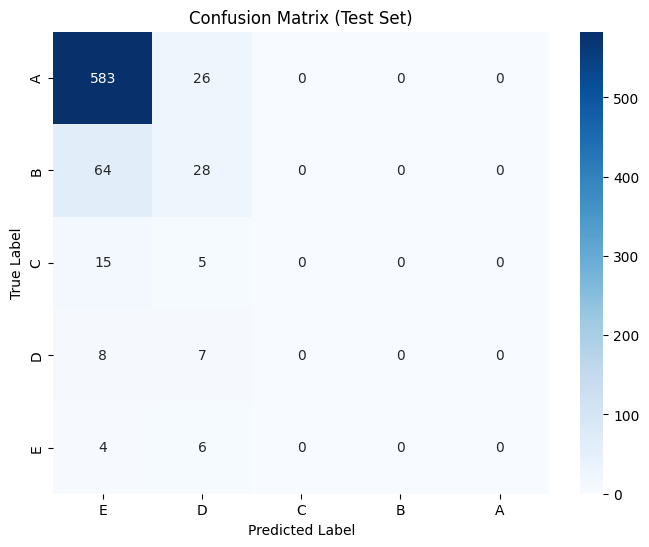

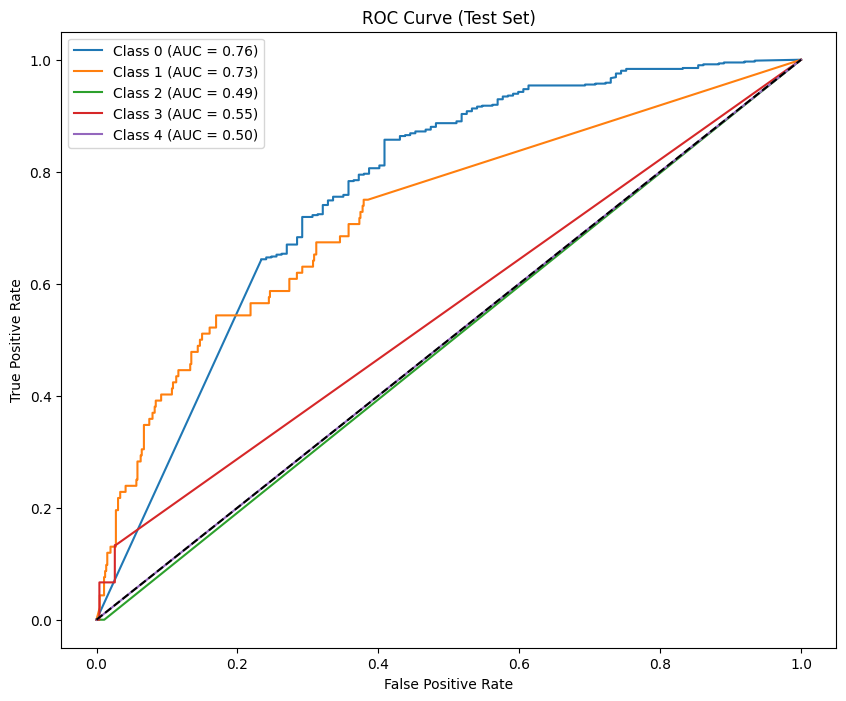

Train F1: [0.87986957 0.70439704 0.56763926 0.59854015 0.73333333] | Test F1: [0.90880748 0.34146341 0.         0.         0.        ]
Train Precision: [0.84968512 0.75220828 0.72789116 0.67955801 0.62857143] | Test Precision: [0.86498516 0.38888889 0.         0.         0.        ]
Train Recall: [0.91227758 0.66230045 0.46521739 0.53478261 0.88      ] | Test Recall: [0.95730706 0.30434783 0.         0.         0.        ]
Train Accuracy: 0.8185540477304633 | Test Accuracy: 0.8190348525469169
Train Auc: 0.9337556796845838 | Test Auc: 0.6080169176771355
Test predictions saved as test_results_standard_f1_macro_phase2.csv

=== Evaluation after calibration for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.84321238 0.50941105 0.         0.         0.38709677]
Precision (per class): [0.72968405 0.98589894 0.         0.         1.        ]
Recall (per class): [0.99857651 0.34343021 0.         0.         0.24      ]
Accuracy: 0.7553813757604118
AUC (One-vs-Rest): 0.9455260

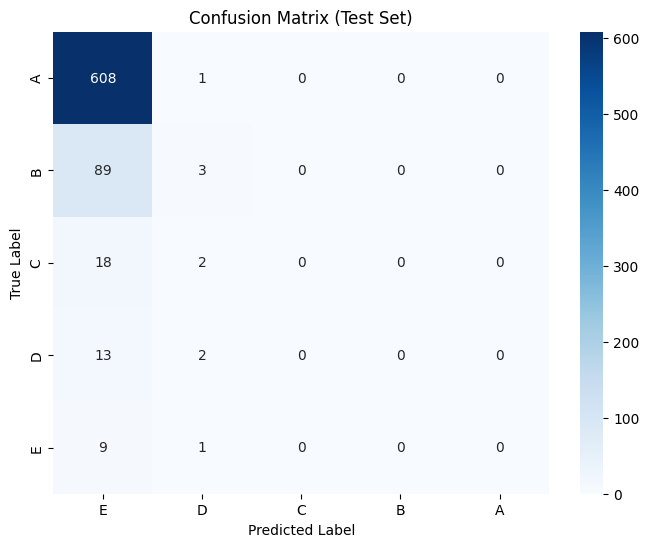

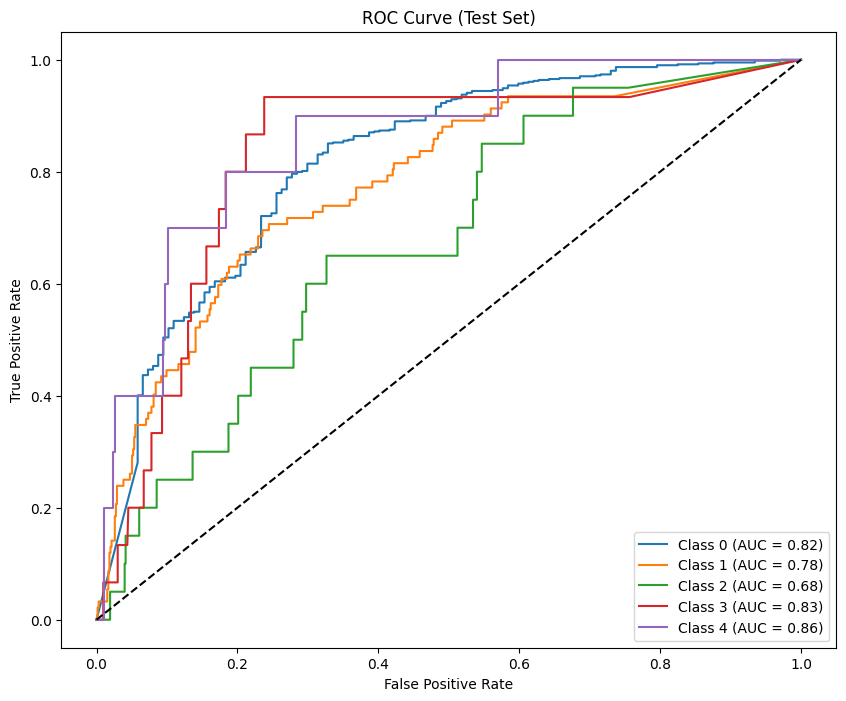

Train F1 (calibrated): [0.84321238 0.50941105 0.         0.         0.38709677] | Test F1 (calibrated): [0.90341753 0.05940594 0.         0.         0.        ]
Train Precision (calibrated): [0.72968405 0.98589894 0.         0.         1.        ] | Test Precision (calibrated): [0.82496608 0.33333333 0.         0.         0.        ]
Train Recall (calibrated): [0.99857651 0.34343021 0.         0.         0.24      ] | Test Recall (calibrated): [0.99835796 0.0326087  0.         0.         0.        ]
Train Accuracy (calibrated): 0.7553813757604118 | Test Accuracy (calibrated): 0.8190348525469169
Train Auc (calibrated): 0.9455260924694725 | Test Auc (calibrated): 0.7928179553449667
Calibrated predictions saved as test_results_calibrate_standard_f1_macro_phase2.csv

=== Permutation Importance for phase phase2 ===


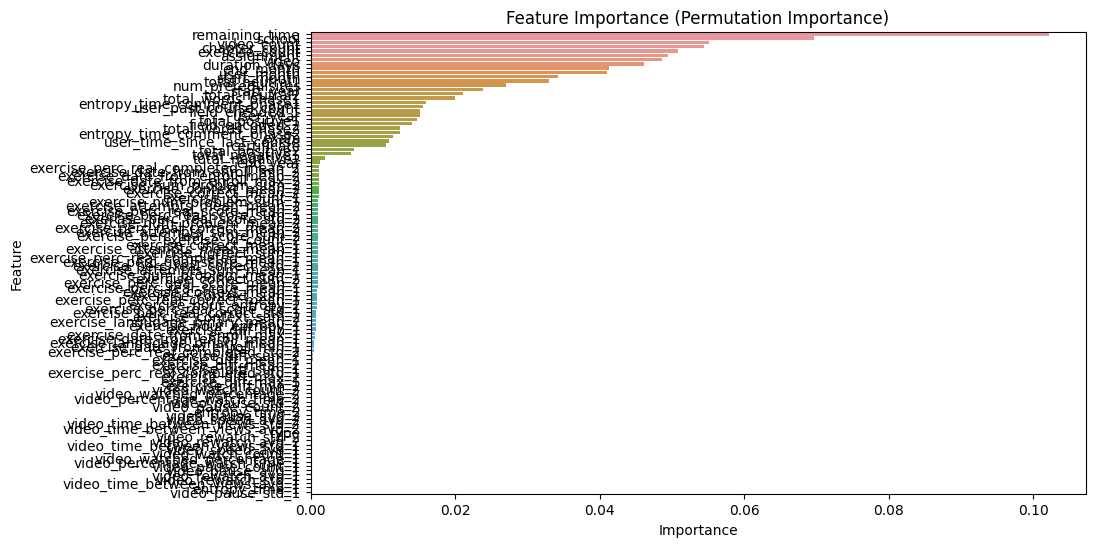


=== Lasso Feature Selection for phase phase2 ===


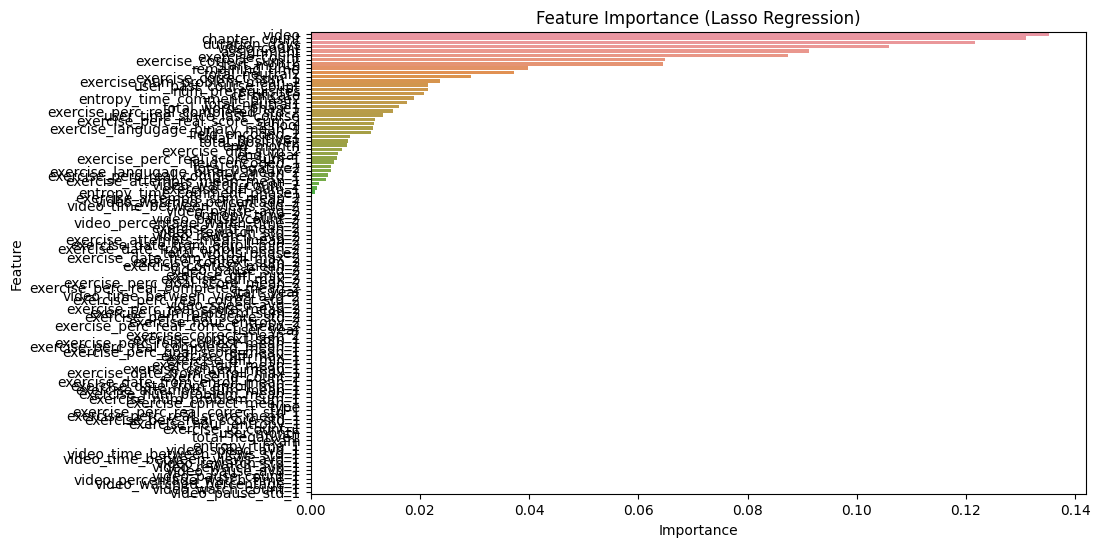

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Columns: 156 entries, user_id to label_encoded
dtypes: float64(143), int64(9), object(4)
memory usage: 9.3+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Parameters for phase phase3: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'} ===

=== Evaluation for phase phase3 ===

====== Train Set ======
F1 Score (per class): [0.88586227 0.73199635 0.60625    0.61971831 0.69565217]
Precision (per class): [0.87099208 0.75469925 0.76377953 0.60273973 0.59259259]
Recall (per class): [0.90124902 0.71061947 0.50259067 0.63768116 0.84210526]
Accuracy: 0.829040112777137
AUC (One-vs-Rest): 0.9414668280578112

====== Test Set ======
F1 Score (per class): [0.8859166 0.112     0.        0.        0.       ]
Precision (per class): [0.82430454 0.18421053 0.         0.         0.        ]
Recall (per class): [0.95748299 0.08045977 0.         0.         0.        ]
Accuracy: 0.7905686546

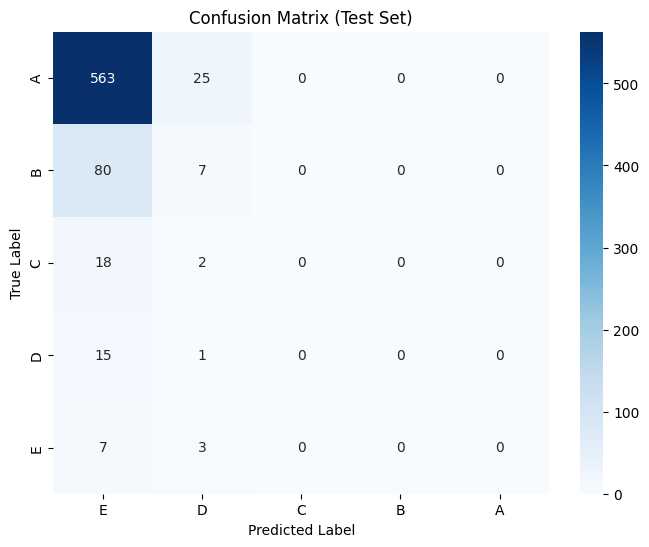

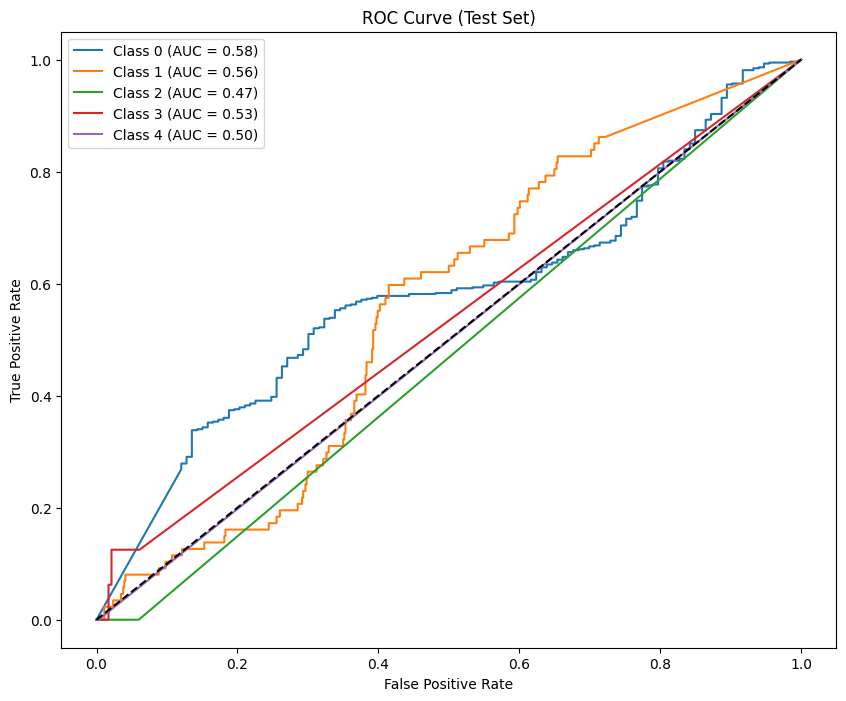

Train F1: [0.88586227 0.73199635 0.60625    0.61971831 0.69565217] | Test F1: [0.8859166 0.112     0.        0.        0.       ]
Train Precision: [0.87099208 0.75469925 0.76377953 0.60273973 0.59259259] | Test Precision: [0.82430454 0.18421053 0.         0.         0.        ]
Train Recall: [0.90124902 0.71061947 0.50259067 0.63768116 0.84210526] | Test Recall: [0.95748299 0.08045977 0.         0.         0.        ]
Train Accuracy: 0.829040112777137 | Test Accuracy: 0.7905686546463245
Train Auc: 0.9414668280578112 | Test Auc: 0.5275775554199973
Test predictions saved as test_results_standard_f1_macro_phase3.csv

=== Evaluation after calibration for phase phase3 ===

====== Train Set ======
F1 Score (per class): [0.85750273 0.59489388 0.         0.20779221 0.27272727]
Precision (per class): [0.75254237 0.97578204 0.         1.         1.        ]
Recall (per class): [0.99648712 0.42787611 0.         0.11594203 0.15789474]
Accuracy: 0.7817506087402282
AUC (One-vs-Rest): 0.9488343945628

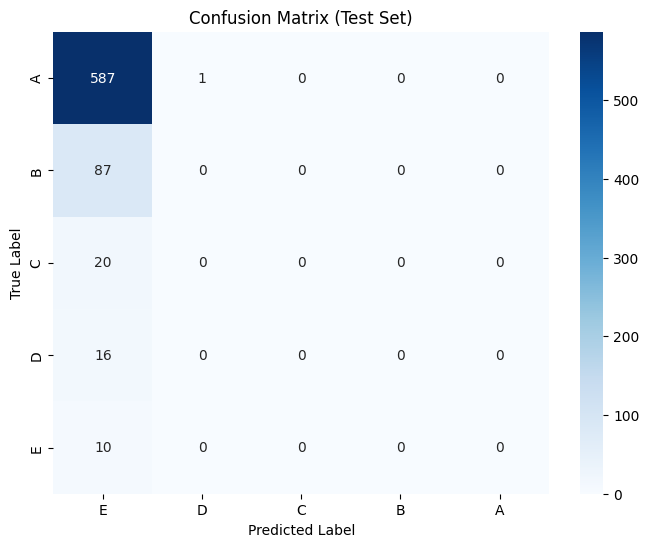

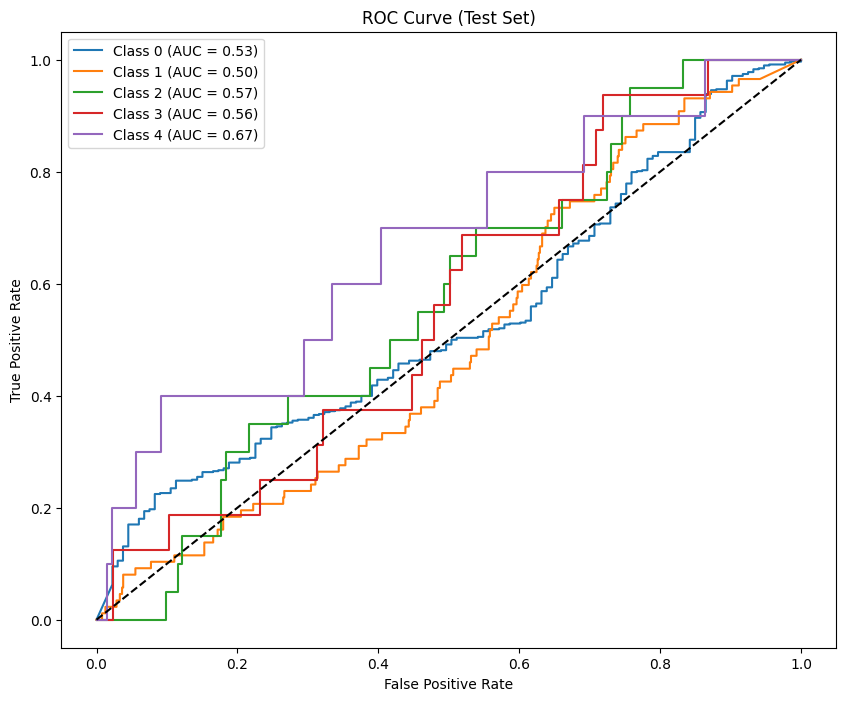

Train F1 (calibrated): [0.85750273 0.59489388 0.         0.20779221 0.27272727] | Test F1 (calibrated): [0.89755352 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.75254237 0.97578204 0.         1.         1.        ] | Test Precision (calibrated): [0.81527778 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99648712 0.42787611 0.         0.11594203 0.15789474] | Test Recall (calibrated): [0.99829932 0.         0.         0.         0.        ]
Train Accuracy (calibrated): 0.7817506087402282 | Test Accuracy (calibrated): 0.8141470180305131
Train Auc (calibrated): 0.9488343945628289 | Test Auc (calibrated): 0.5649502971020002
Calibrated predictions saved as test_results_calibrate_standard_f1_macro_phase3.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Columns: 199 entries, user_id to label_encoded
dtypes: float64(186), int64(9), object(4)
memory usage: 8.1+ MB
None
Fitting 5 folds for each of 10 candid

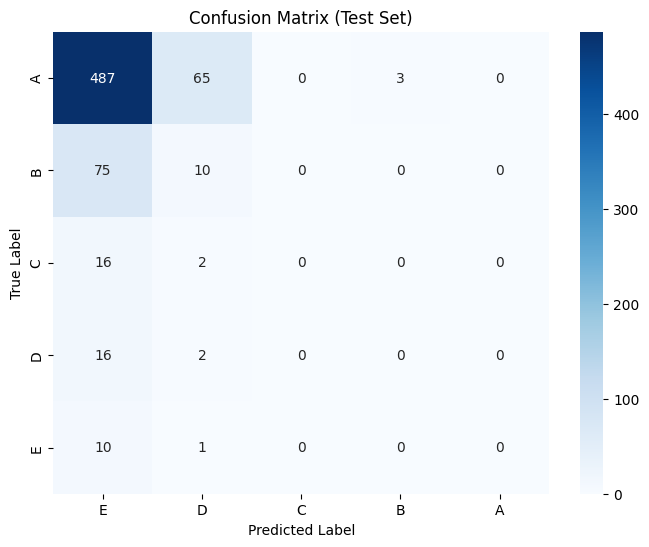

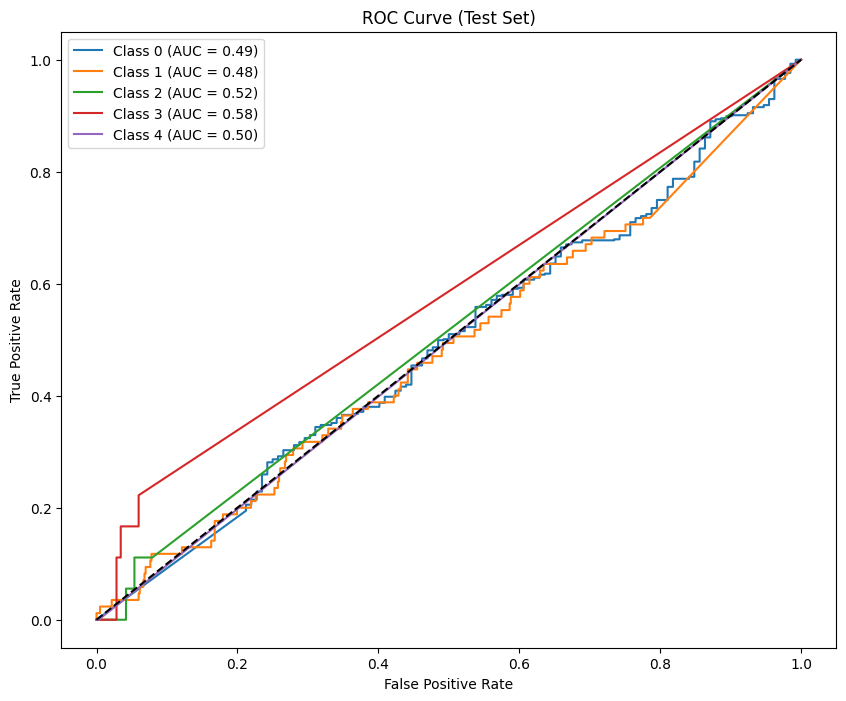

Train F1: [0.89535365 0.75873544 0.66666667 0.69343066 0.68421053] | Test F1: [0.84037964 0.12121212 0.         0.         0.        ]
Train Precision: [0.86679124 0.80112439 0.94545455 0.82608696 0.54166667] | Test Precision: [0.80629139 0.125      0.         0.         0.        ]
Train Recall: [0.92586256 0.72060683 0.51485149 0.59748428 0.92857143] | Test Recall: [0.87747748 0.11764706 0.         0.         0.        ]
Train Accuracy: 0.8478463546522469 | Test Accuracy: 0.7234352256186317
Train Auc: 0.9411825379573177 | Test Auc: 0.5135557163624179
Test predictions saved as test_results_standard_f1_macro_phase4.csv

=== Evaluation after calibration for phase phase4 ===

====== Train Set ======
F1 Score (per class): [0.87720181 0.6647351  0.22807018 0.61471861 0.35294118]
Precision (per class): [0.78495834 0.96282974 1.         0.98611111 1.        ]
Recall (per class): [0.99401198 0.50758534 0.12871287 0.44654088 0.21428571]
Accuracy: 0.8159612157374604
AUC (One-vs-Rest): 0.9458576

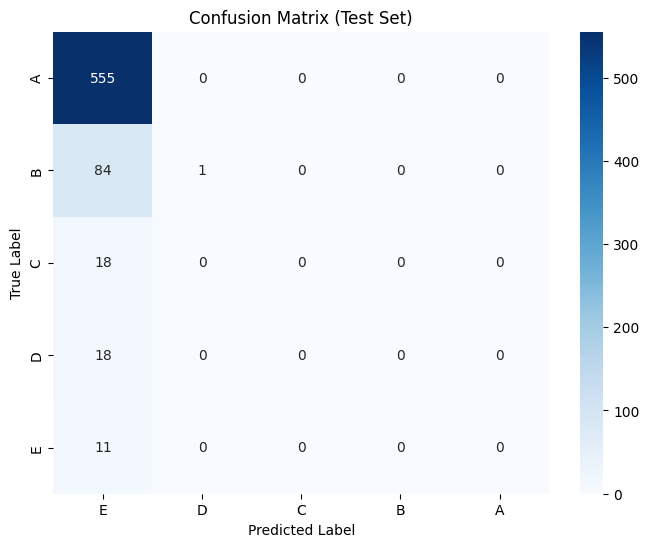

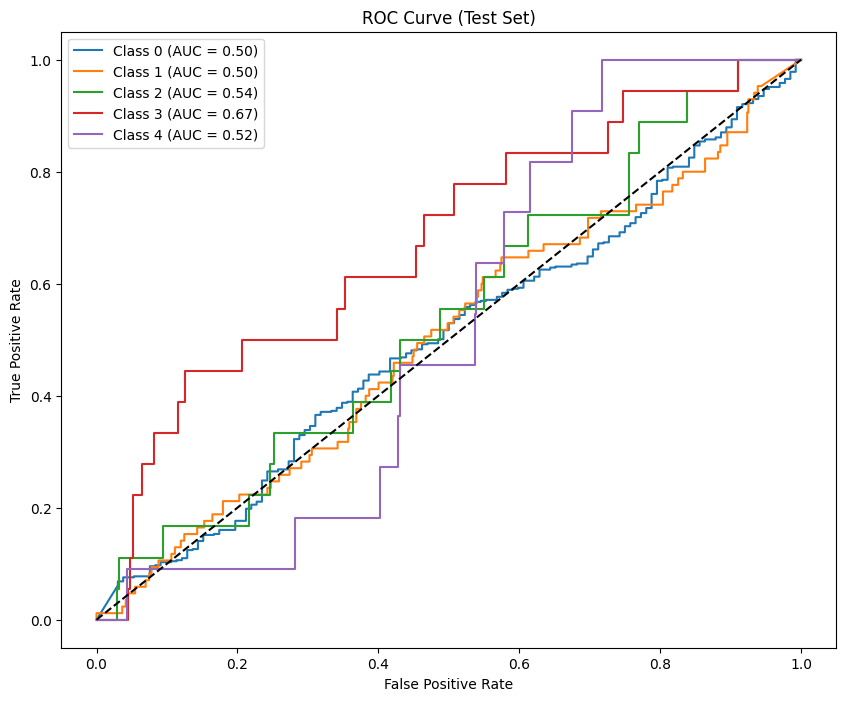

Train F1 (calibrated): [0.87720181 0.6647351  0.22807018 0.61471861 0.35294118] | Test F1 (calibrated): [0.89443997 0.02325581 0.         0.         0.        ]
Train Precision (calibrated): [0.78495834 0.96282974 1.         0.98611111 1.        ] | Test Precision (calibrated): [0.8090379 1.        0.        0.        0.       ]
Train Recall (calibrated): [0.99401198 0.50758534 0.12871287 0.44654088 0.21428571] | Test Recall (calibrated): [1.         0.01176471 0.         0.         0.        ]
Train Accuracy (calibrated): 0.8159612157374604 | Test Accuracy (calibrated): 0.8093158660844251
Train Auc (calibrated): 0.9458576656652916 | Test Auc (calibrated): 0.5469456994774654
Calibrated predictions saved as test_results_calibrate_standard_f1_macro_phase4.csv


In [13]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    process_phase(phase, metric='f1_macro')

# 2. Minmax

In [19]:
from sklearn.neighbors import KNeighborsClassifier

def process_phase(phase, scale='minmax', metric='accuracy'):
    # Đọc dữ liệu
    X_train, y_train, X_test, y_test = load_data(phase)

    # Scale dữ liệu
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaler_type=scale)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Thiết lập StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Định nghĩa mô hình KNN
    model = KNeighborsClassifier()

    # Tham số tìm kiếm cho KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=skf,
        scoring=metric,
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    # Huấn luyện mô hình
    randomized_search.fit(X_train_scaled, y_train)

    # In tham số tốt nhất
    best_params = randomized_search.best_params_
    print(f"\n=== Best Parameters for phase {phase}: {best_params} ===")

    # Đánh giá mô hình gốc
    print(f"\n=== Evaluation for phase {phase} ===")
    evaluation_results = evaluate_model(
        randomized_search.best_estimator_,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # Lấy các kết quả từ evaluation_results
    train_results = evaluation_results['train']
    test_results = evaluation_results['test']

    # In kết quả
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()}: {train_results[metric_name]} | Test {metric_name.capitalize()}: {test_results[metric_name]}")

    # Lưu kết quả dự đoán
    y_pred = randomized_search.best_estimator_.predict(X_test_scaled)
    results_df = X_test.copy()
    results_df['True_Label'] = y_test
    results_df['Predicted_Label'] = y_pred
    results_filename = f"test_results_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"Test predictions saved as {results_filename}")

    # Calibrate model (sử dụng Platt scaling với KNN)
    calibrate_train_model = calibrate_model(randomized_search.best_estimator_, X_train_scaled, y_train)

    # Đánh giá mô hình sau calibrate
    print(f"\n=== Evaluation after calibration for phase {phase} ===")
    evaluation_results_cal = evaluate_model(
        calibrate_train_model,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # In kết quả sau hiệu chuẩn
    train_results_cal = evaluation_results_cal['train']
    test_results_cal = evaluation_results_cal['test']
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()} (calibrated): {train_results_cal[metric_name]} | Test {metric_name.capitalize()} (calibrated): {test_results_cal[metric_name]}")

    # Lưu kết quả dự đoán sau calibrate
    y_calibrate_pred = calibrate_train_model.predict(X_test_scaled)
    results_df['Calibrated_Predicted_Label'] = y_calibrate_pred
    results_calibrate_filename = f"test_results_calibrate_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_calibrate_filename, index=False)
    print(f"Calibrated predictions saved as {results_calibrate_filename}")

    # Nếu phase 1 hoặc 2 → chạy chọn feature
    if int(phase[-1]) <= 2:
        print(f"\n=== Permutation Importance for phase {phase} ===")
        perm_importance = plot_permutation_importance(randomized_search.best_estimator_, X_train_scaled, y_train)

        print(f"\n=== Lasso Feature Selection for phase {phase} ===")
        lasso_importance = lasso_feature_selection(X_train_scaled, y_train)

        # model_with_best_params = KNeighborsClassifier(**best_params)
        # print("\n=== Boruta Trick ===")
        # important_features = boruta_trick(model_with_best_params, X_train_scaled, y_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   user_id                              10570 non-null  object 
 1   school                               6715 non-null   object 
 2   course_id                            10570 non-null  object 
 3   field_encoded_1                      10570 non-null  int64  
 4   field_encoded_2                      10570 non-null  int64  
 5   start_year                           10570 non-null  float64
 6   start_month                          10570 non-null  float64
 7   end_year                             10570 non-null  float64
 8   end_month                            10570 non-null  float64
 9   user_year                            10570 non-null  float64
 10  user_month                           10570 non-null  float64
 11  video_count                 

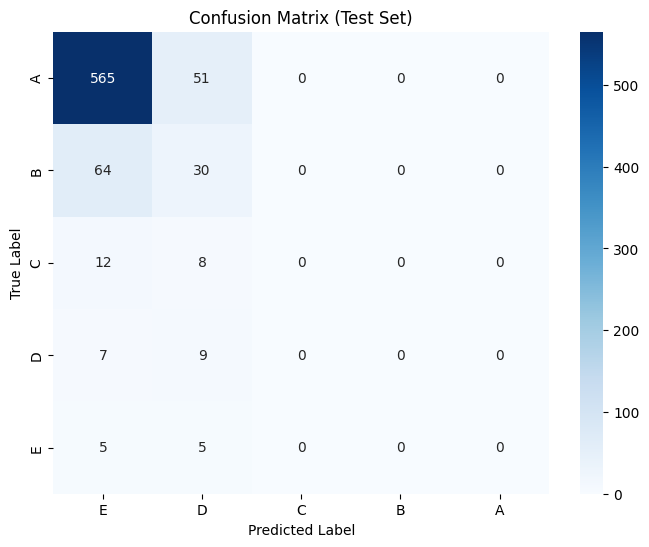

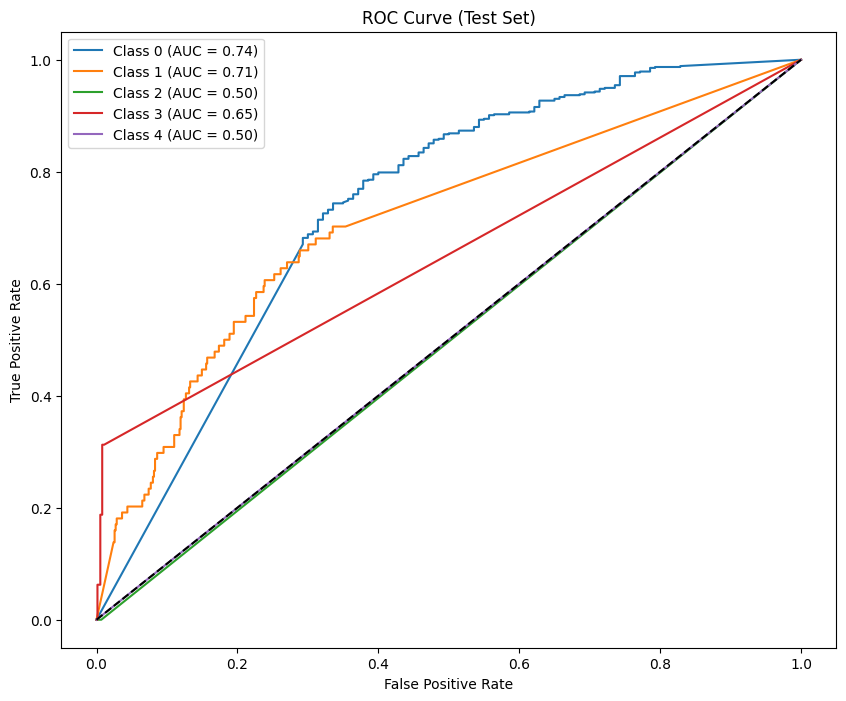

Train F1: [0.88471368 0.72410792 0.58852868 0.59649123 0.6557377 ] | Test F1: [0.89046493 0.30456853 0.         0.         0.        ]
Train Precision: [0.85216234 0.7743857  0.90076336 0.66666667 0.58823529] | Test Precision: [0.86523737 0.29126214 0.         0.         0.        ]
Train Recall: [0.91985062 0.67996077 0.43703704 0.53968254 0.74074074] | Test Recall: [0.91720779 0.31914894 0.         0.         0.        ]
Train Accuracy: 0.8285714285714286 | Test Accuracy: 0.7870370370370371
Train Auc: 0.9347643620733737 | Test Auc: 0.6186877259414978
Test predictions saved as test_results_minmax_f1_macro_phase1.csv

=== Evaluation after calibration for phase phase1 ===

====== Train Set ======
F1 Score (per class): [0.8635628  0.63230088 0.         0.         0.25      ]
Precision (per class): [0.76197276 0.97809719 0.         0.         0.8       ]
Recall (per class): [0.99640908 0.46714613 0.         0.         0.14814815]
Accuracy: 0.7918637653736992
AUC (One-vs-Rest): 0.949208507

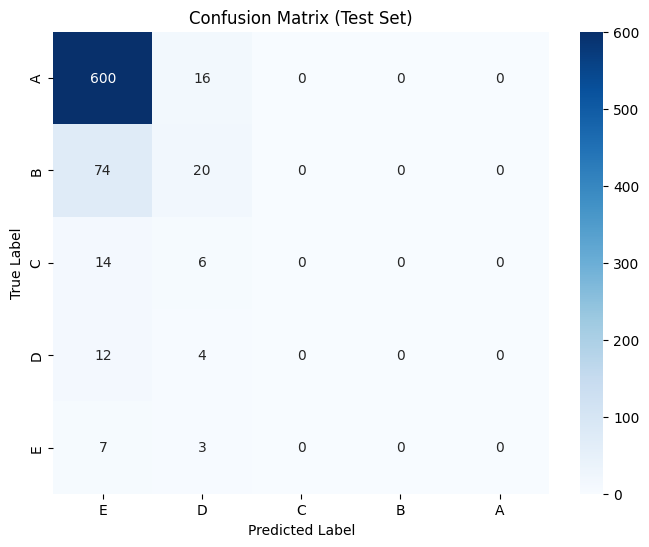

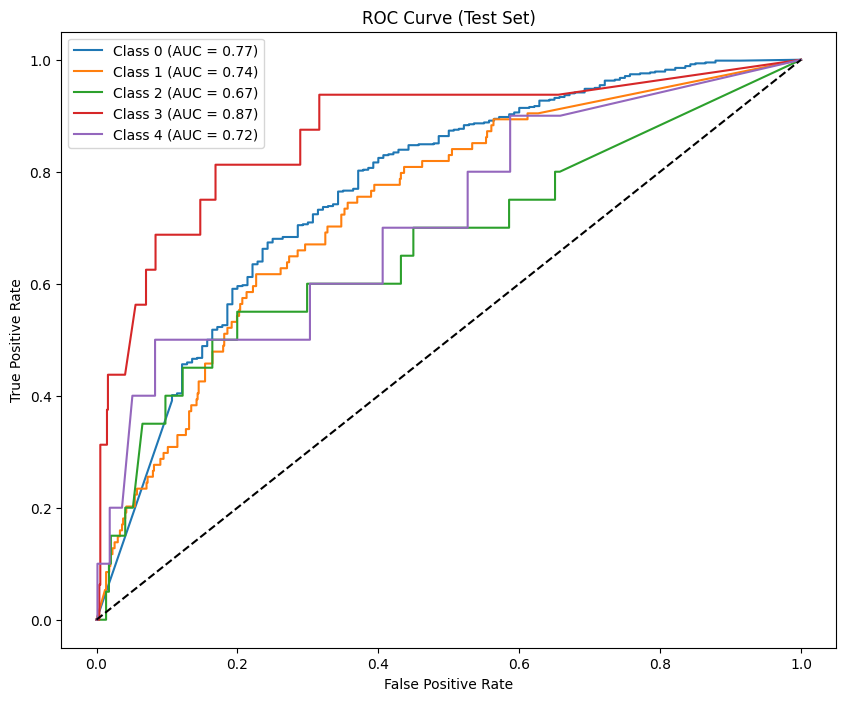

Train F1 (calibrated): [0.8635628  0.63230088 0.         0.         0.25      ] | Test F1 (calibrated): [0.90702948 0.27972028 0.         0.         0.        ]
Train Precision (calibrated): [0.76197276 0.97809719 0.         0.         0.8       ] | Test Precision (calibrated): [0.84865629 0.40816327 0.         0.         0.        ]
Train Recall (calibrated): [0.99640908 0.46714613 0.         0.         0.14814815] | Test Recall (calibrated): [0.97402597 0.21276596 0.         0.         0.        ]
Train Accuracy (calibrated): 0.7918637653736992 | Test Accuracy (calibrated): 0.8201058201058201
Train Auc (calibrated): 0.9492085077739782 | Test Auc (calibrated): 0.7537791336643628
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase1.csv

=== Permutation Importance for phase phase1 ===


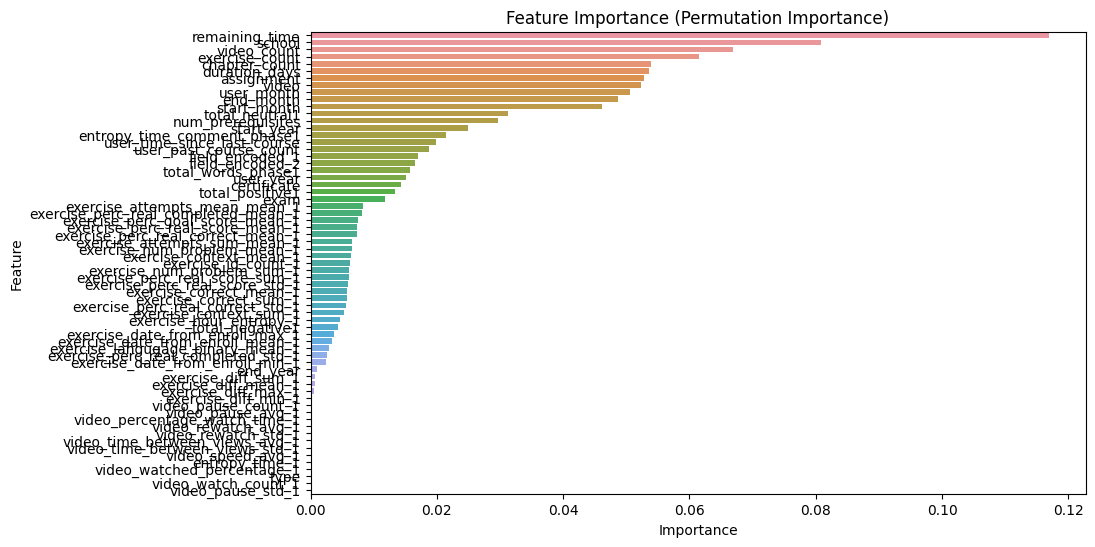


=== Lasso Feature Selection for phase phase1 ===


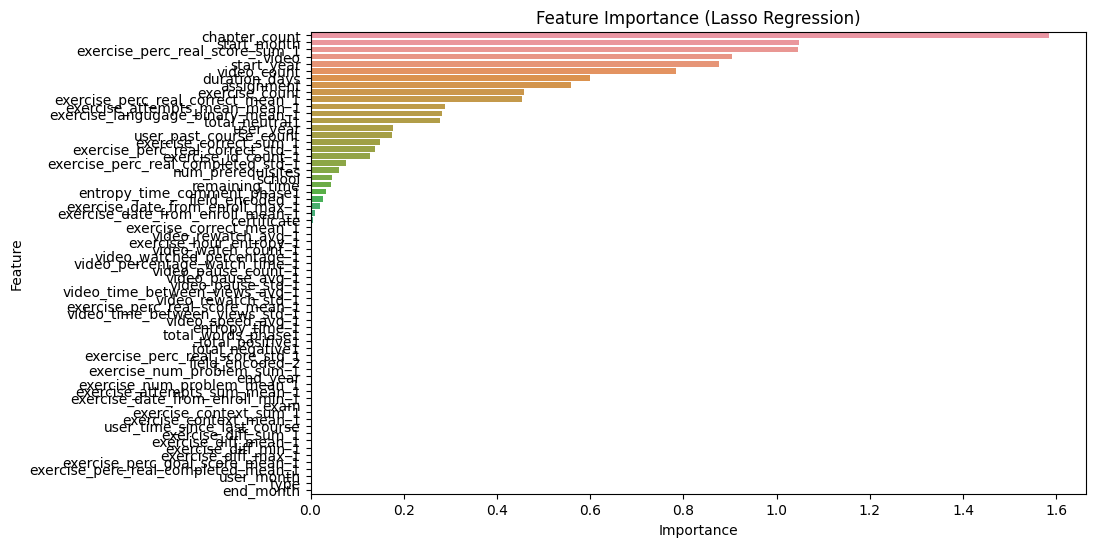

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Columns: 113 entries, user_id to label_encoded
dtypes: float64(100), int64(9), object(4)
memory usage: 7.4+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Parameters for phase phase2: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'} ===

=== Evaluation for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.87982132 0.7046542  0.57217848 0.60096154 0.73333333]
Precision (per class): [0.85052317 0.75174014 0.7218543  0.67204301 0.62857143]
Recall (per class): [0.91120996 0.66311912 0.47391304 0.54347826 0.88      ]
Accuracy: 0.8185540477304633
AUC (One-vs-Rest): 0.9324465782451414

====== Test Set ======
F1 Score (per class): [0.91344668 0.33986928 0.         0.         0.        ]
Precision (per class): [0.86277372 0.42622951 0.         0.         0.        ]
Recall (per class): [0.97044335 0.2826087  0.         0.         0.        ]
Accuracy: 0.8270

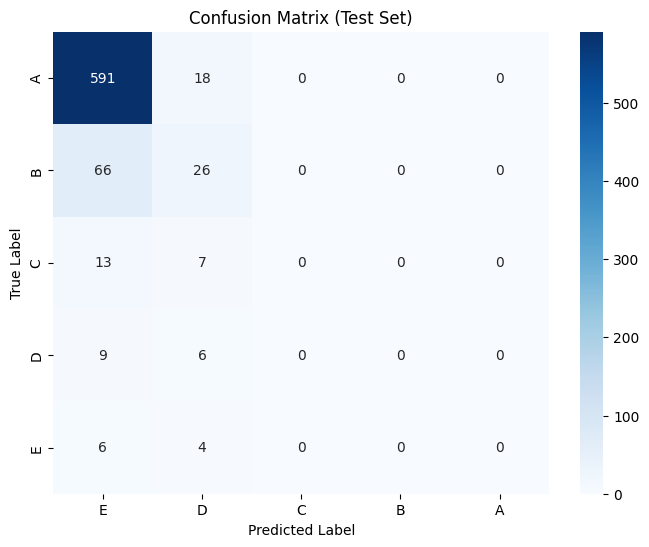

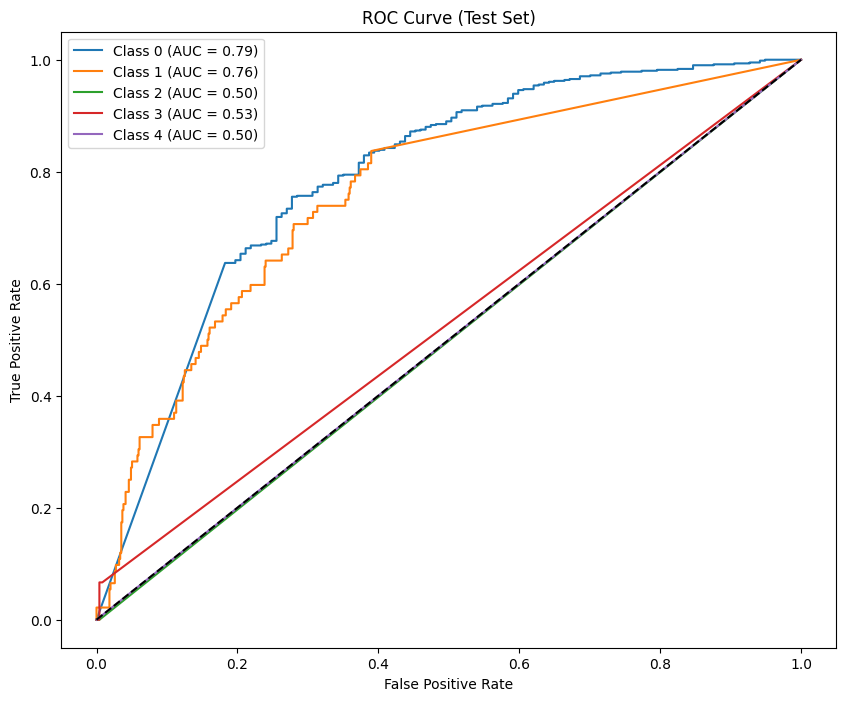

Train F1: [0.87982132 0.7046542  0.57217848 0.60096154 0.73333333] | Test F1: [0.91344668 0.33986928 0.         0.         0.        ]
Train Precision: [0.85052317 0.75174014 0.7218543  0.67204301 0.62857143] | Test Precision: [0.86277372 0.42622951 0.         0.         0.        ]
Train Recall: [0.91120996 0.66311912 0.47391304 0.54347826 0.88      ] | Test Recall: [0.97044335 0.2826087  0.         0.         0.        ]
Train Accuracy: 0.8185540477304633 | Test Accuracy: 0.8270777479892761
Train Auc: 0.9324465782451414 | Test Auc: 0.6154968304249826
Test predictions saved as test_results_minmax_f1_macro_phase2.csv

=== Evaluation after calibration for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.83819906 0.47307812 0.         0.         0.33333333]
Precision (per class): [0.72211501 0.98701299 0.         0.         1.        ]
Recall (per class): [0.99875445 0.31109292 0.         0.         0.2       ]
Accuracy: 0.7461394478240524
AUC (One-vs-Rest): 0.944837402

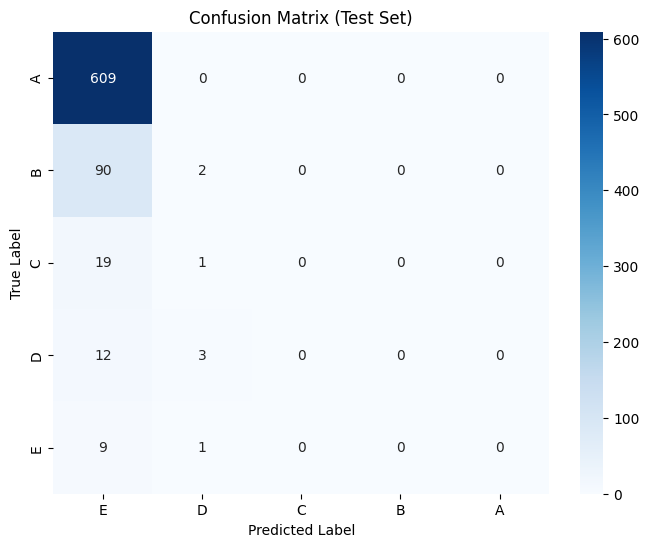

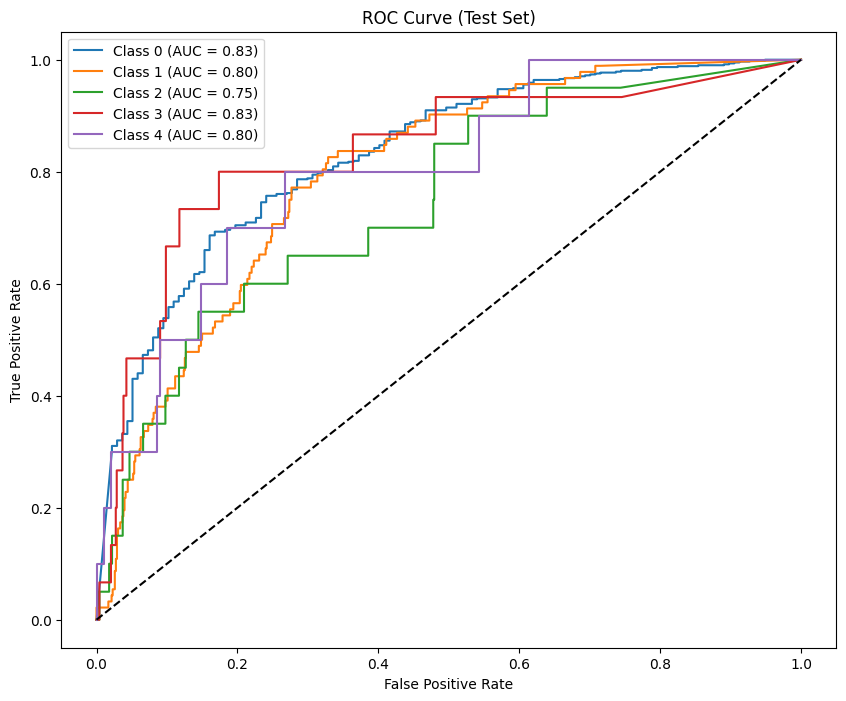

Train F1 (calibrated): [0.83819906 0.47307812 0.         0.         0.33333333] | Test F1 (calibrated): [0.90356083 0.04040404 0.         0.         0.        ]
Train Precision (calibrated): [0.72211501 0.98701299 0.         0.         1.        ] | Test Precision (calibrated): [0.8240866  0.28571429 0.         0.         0.        ]
Train Recall (calibrated): [0.99875445 0.31109292 0.         0.         0.2       ] | Test Recall (calibrated): [1.         0.02173913 0.         0.         0.        ]
Train Accuracy (calibrated): 0.7461394478240524 | Test Accuracy (calibrated): 0.8190348525469169
Train Auc (calibrated): 0.9448374026370198 | Test Auc (calibrated): 0.8024373547352475
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase2.csv

=== Permutation Importance for phase phase2 ===


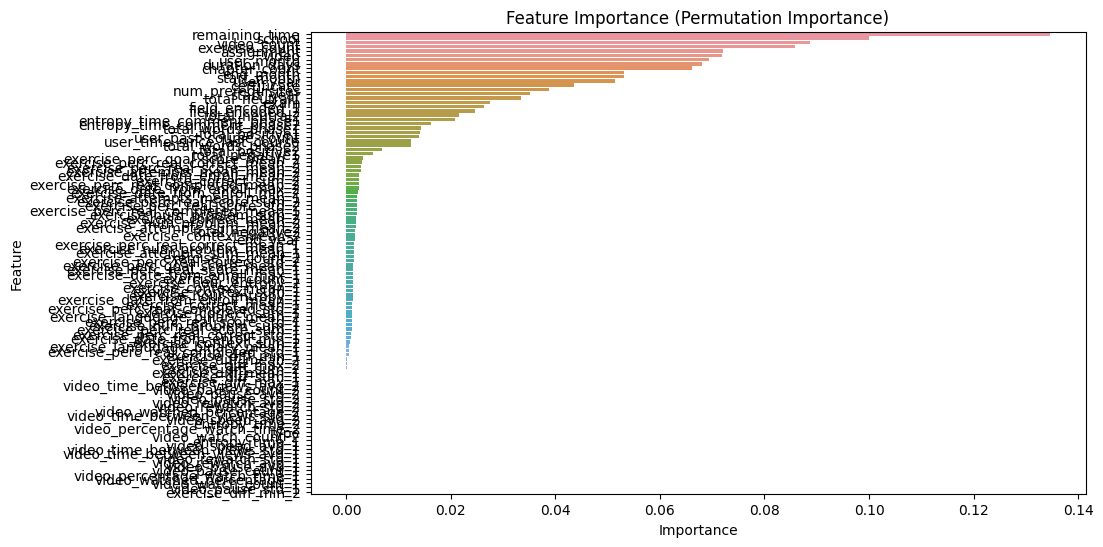


=== Lasso Feature Selection for phase phase2 ===


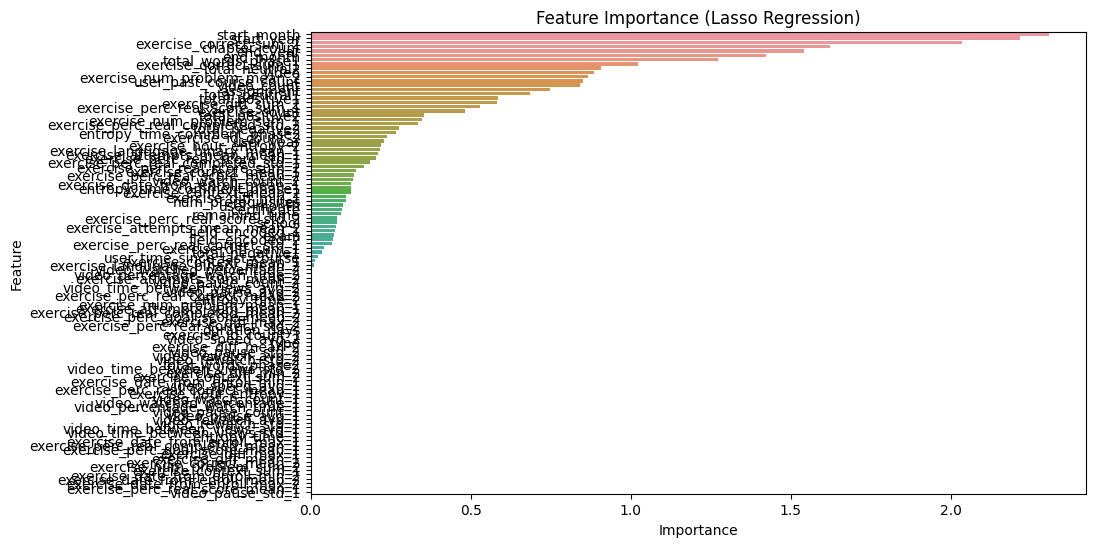

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Columns: 156 entries, user_id to label_encoded
dtypes: float64(143), int64(9), object(4)
memory usage: 9.3+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=   2.5s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=   2.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.2s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   1.6s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   1.5s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   1.5s
[CV] END ...metric=

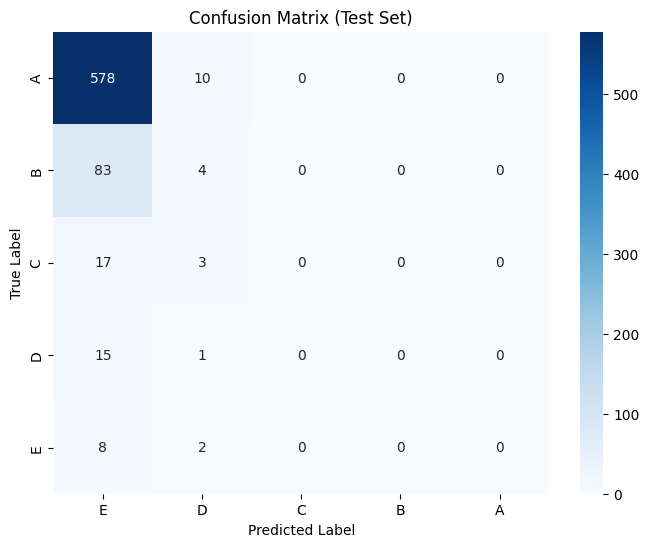

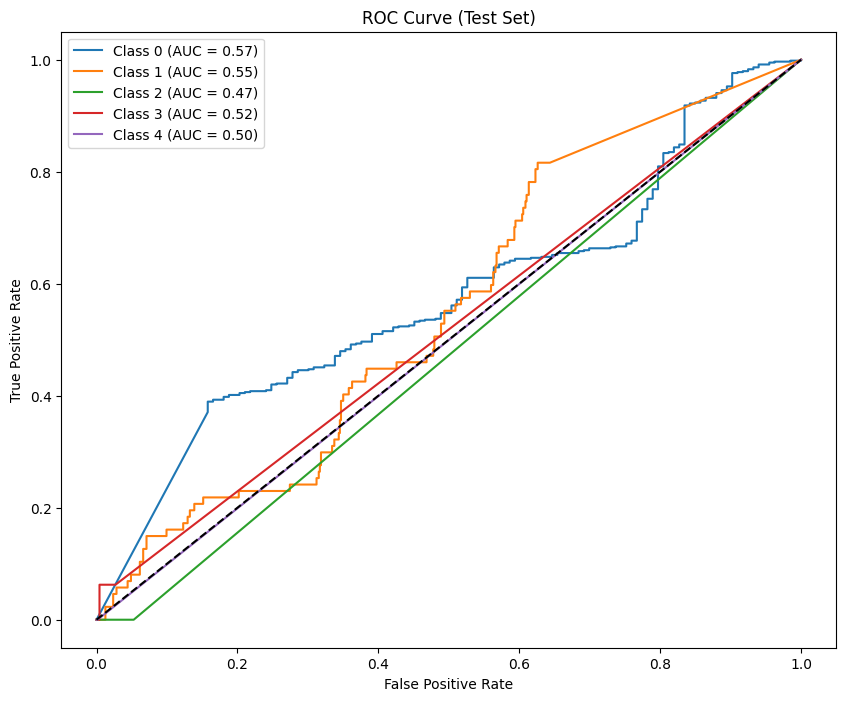

Train F1: [0.88586227 0.73199635 0.60625    0.61971831 0.69565217] | Test F1: [0.89681924 0.07476636 0.         0.         0.        ]
Train Precision: [0.87099208 0.75469925 0.76377953 0.60273973 0.59259259] | Test Precision: [0.82453638 0.2        0.         0.         0.        ]
Train Recall: [0.90124902 0.71061947 0.50259067 0.63768116 0.84210526] | Test Recall: [0.9829932  0.04597701 0.         0.         0.        ]
Train Accuracy: 0.829040112777137 | Test Accuracy: 0.8072122052704577
Train Auc: 0.9414668280578112 | Test Auc: 0.5234337416540417
Test predictions saved as test_results_minmax_f1_macro_phase3.csv

=== Evaluation after calibration for phase phase3 ===

====== Train Set ======
F1 Score (per class): [0.85299516 0.56539552 0.         0.20779221 0.34782609]
Precision (per class): [0.74497231 0.98247536 0.         1.         1.        ]
Recall (per class): [0.99765808 0.39690265 0.         0.11594203 0.21052632]
Accuracy: 0.773676790977829
AUC (One-vs-Rest): 0.94755534456

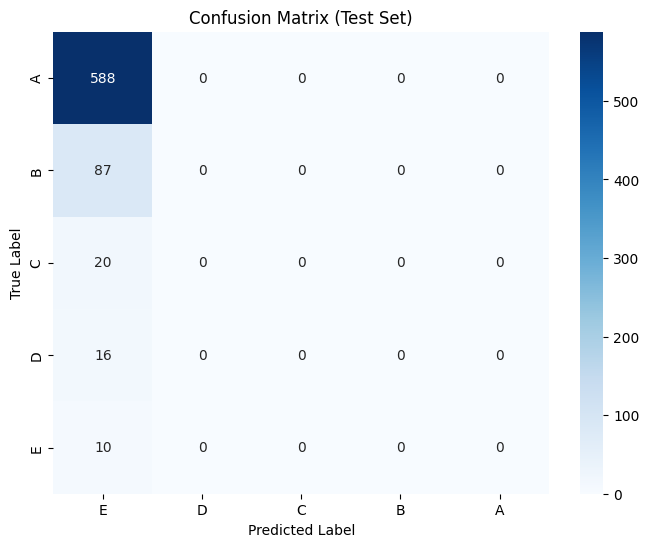

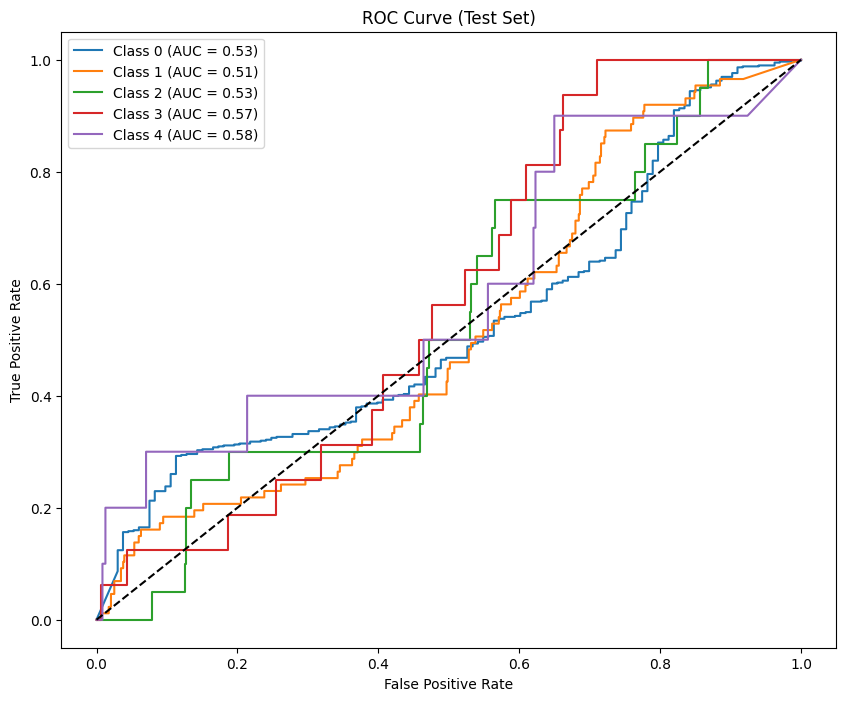

Train F1 (calibrated): [0.85299516 0.56539552 0.         0.20779221 0.34782609] | Test F1 (calibrated): [0.89839572 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.74497231 0.98247536 0.         1.         1.        ] | Test Precision (calibrated): [0.81553398 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99765808 0.39690265 0.         0.11594203 0.21052632] | Test Recall (calibrated): [1. 0. 0. 0. 0.]
Train Accuracy (calibrated): 0.773676790977829 | Test Accuracy (calibrated): 0.8155339805825242
Train Auc (calibrated): 0.9475553445687112 | Test Auc (calibrated): 0.5438876475341305
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase3.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Columns: 199 entries, user_id to label_encoded
dtypes: float64(186), int64(9), object(4)
memory usage: 8.1+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[CV] END ..metric=

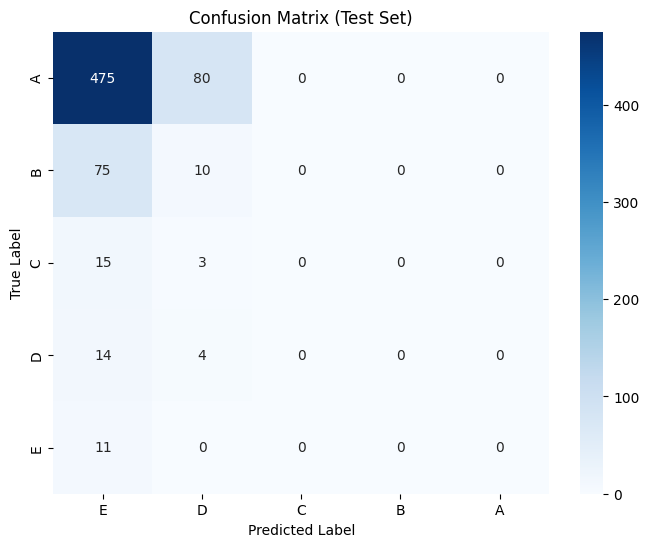

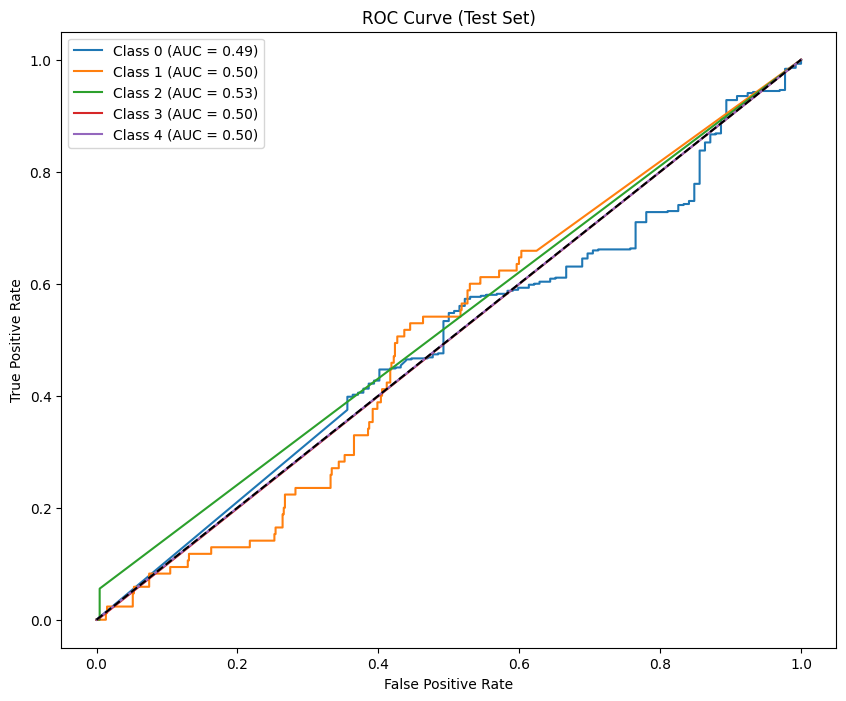

Train F1: [0.89518805 0.75992063 0.66233766 0.69784173 0.68421053] | Test F1: [0.82969432 0.10989011 0.         0.         0.        ]
Train Precision: [0.86899329 0.79680999 0.96226415 0.81512605 0.54166667] | Test Precision: [0.80508475 0.10309278 0.         0.         0.        ]
Train Recall: [0.92301112 0.72629583 0.5049505  0.61006289 0.92857143] | Test Recall: [0.85585586 0.11764706 0.         0.         0.        ]
Train Accuracy: 0.8478463546522469 | Test Accuracy: 0.7059679767103348
Train Auc: 0.9399606995626859 | Test Auc: 0.5034912414332153
Test predictions saved as test_results_minmax_f1_macro_phase4.csv

=== Evaluation after calibration for phase phase4 ===

====== Train Set ======
F1 Score (per class): [0.87226323 0.63881857 0.30252101 0.59030837 0.35294118]
Precision (per class): [0.77708426 0.9606599  1.         0.98529412 1.        ]
Recall (per class): [0.99401198 0.47850822 0.17821782 0.42138365 0.21428571]
Accuracy: 0.8075703897072534
AUC (One-vs-Rest): 0.944315559

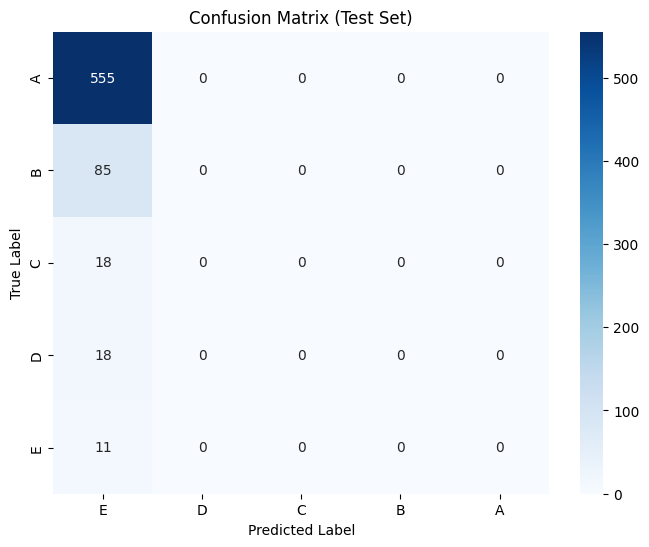

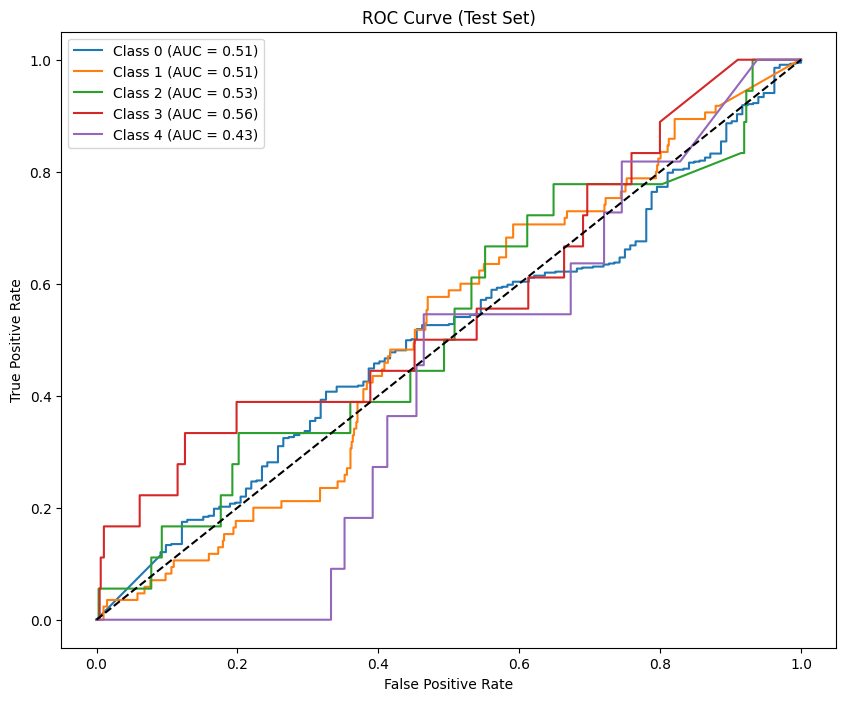

Train F1 (calibrated): [0.87226323 0.63881857 0.30252101 0.59030837 0.35294118] | Test F1 (calibrated): [0.89371981 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.77708426 0.9606599  1.         0.98529412 1.        ] | Test Precision (calibrated): [0.80786026 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99401198 0.47850822 0.17821782 0.42138365 0.21428571] | Test Recall (calibrated): [1. 0. 0. 0. 0.]
Train Accuracy (calibrated): 0.8075703897072534 | Test Accuracy (calibrated): 0.8078602620087336
Train Auc (calibrated): 0.9443155597623145 | Test Auc (calibrated): 0.5072178916960149
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase4.csv

[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   1.5s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   1.5s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   1.6s
[CV] END ..metric=manhatt

In [20]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    process_phase(phase, metric='f1_macro')

# 3. Robust

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def process_phase(phase, scale='robust', metric='accuracy'):
    # Đọc dữ liệu
    X_train, y_train, X_test, y_test = load_data(phase)

    # Scale dữ liệu
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaler_type=scale)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Thiết lập StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Định nghĩa mô hình KNN
    model = KNeighborsClassifier()

    # Tham số tìm kiếm cho KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=skf,
        scoring=metric,
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    # Huấn luyện mô hình
    randomized_search.fit(X_train_scaled, y_train)

    # In tham số tốt nhất
    best_params = randomized_search.best_params_
    print(f"\n=== Best Parameters for phase {phase}: {best_params} ===")

    # Đánh giá mô hình gốc
    print(f"\n=== Evaluation for phase {phase} ===")
    evaluation_results = evaluate_model(
        randomized_search.best_estimator_,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # Lấy các kết quả từ evaluation_results
    train_results = evaluation_results['train']
    test_results = evaluation_results['test']

    # In kết quả
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()}: {train_results[metric_name]} | Test {metric_name.capitalize()}: {test_results[metric_name]}")

    # Lưu kết quả dự đoán
    y_pred = randomized_search.best_estimator_.predict(X_test_scaled)
    results_df = X_test.copy()
    results_df['True_Label'] = y_test
    results_df['Predicted_Label'] = y_pred
    results_filename = f"test_results_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"Test predictions saved as {results_filename}")

    # Calibrate model (sử dụng Platt scaling với KNN)
    calibrate_train_model = calibrate_model(randomized_search.best_estimator_, X_train_scaled, y_train)

    # Đánh giá mô hình sau calibrate
    print(f"\n=== Evaluation after calibration for phase {phase} ===")
    evaluation_results_cal = evaluate_model(
        calibrate_train_model,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # In kết quả sau hiệu chuẩn
    train_results_cal = evaluation_results_cal['train']
    test_results_cal = evaluation_results_cal['test']
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()} (calibrated): {train_results_cal[metric_name]} | Test {metric_name.capitalize()} (calibrated): {test_results_cal[metric_name]}")

    # Lưu kết quả dự đoán sau calibrate
    y_calibrate_pred = calibrate_train_model.predict(X_test_scaled)
    results_df['Calibrated_Predicted_Label'] = y_calibrate_pred
    results_calibrate_filename = f"test_results_calibrate_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_calibrate_filename, index=False)
    print(f"Calibrated predictions saved as {results_calibrate_filename}")

    # Nếu phase 1 hoặc 2 → chạy chọn feature
    if int(phase[-1]) <= 2:
        print(f"\n=== Permutation Importance for phase {phase} ===")
        perm_importance = plot_permutation_importance(randomized_search.best_estimator_, X_train_scaled, y_train)

        print(f"\n=== Lasso Feature Selection for phase {phase} ===")
        lasso_importance = lasso_feature_selection(X_train_scaled, y_train)

        # model_with_best_params = KNeighborsClassifier(**best_params)
        # print("\n=== Boruta Trick ===")
        # important_features = boruta_trick(model_with_best_params, X_train_scaled, y_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   user_id                              10570 non-null  object 
 1   school                               6715 non-null   object 
 2   course_id                            10570 non-null  object 
 3   field_encoded_1                      10570 non-null  int64  
 4   field_encoded_2                      10570 non-null  int64  
 5   start_year                           10570 non-null  float64
 6   start_month                          10570 non-null  float64
 7   end_year                             10570 non-null  float64
 8   end_month                            10570 non-null  float64
 9   user_year                            10570 non-null  float64
 10  user_month                           10570 non-null  float64
 11  video_count                 

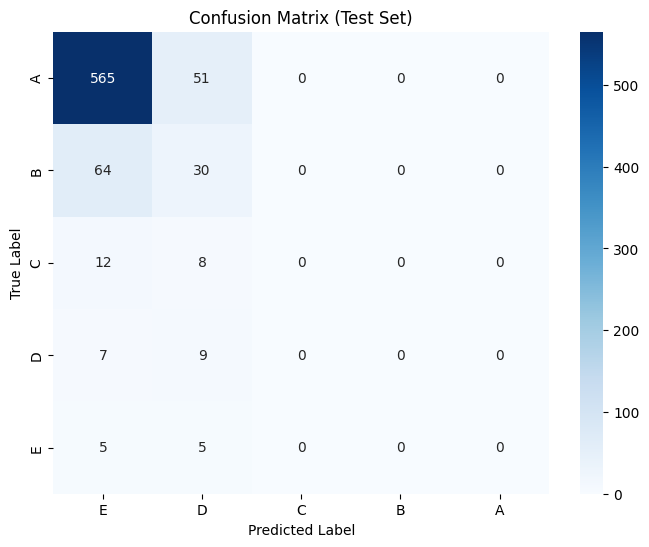

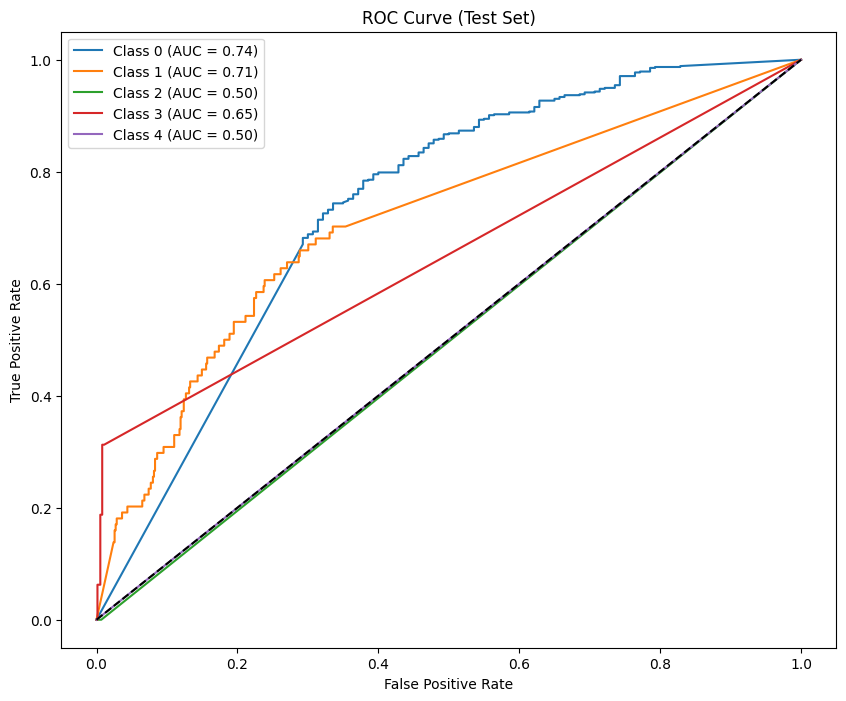

Train F1: [0.88471368 0.72410792 0.58852868 0.59649123 0.6557377 ] | Test F1: [0.89046493 0.30456853 0.         0.         0.        ]
Train Precision: [0.85216234 0.7743857  0.90076336 0.66666667 0.58823529] | Test Precision: [0.86523737 0.29126214 0.         0.         0.        ]
Train Recall: [0.91985062 0.67996077 0.43703704 0.53968254 0.74074074] | Test Recall: [0.91720779 0.31914894 0.         0.         0.        ]
Train Accuracy: 0.8285714285714286 | Test Accuracy: 0.7870370370370371
Train Auc: 0.9347643620733737 | Test Auc: 0.6186877259414978
Test predictions saved as test_results_minmax_f1_macro_phase1.csv

=== Evaluation after calibration for phase phase1 ===

====== Train Set ======
F1 Score (per class): [0.8635628  0.63230088 0.         0.         0.25      ]
Precision (per class): [0.76197276 0.97809719 0.         0.         0.8       ]
Recall (per class): [0.99640908 0.46714613 0.         0.         0.14814815]
Accuracy: 0.7918637653736992
AUC (One-vs-Rest): 0.949208507

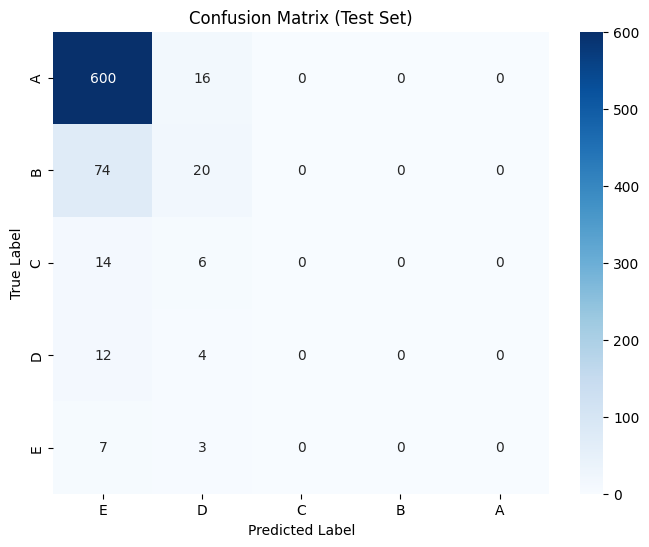

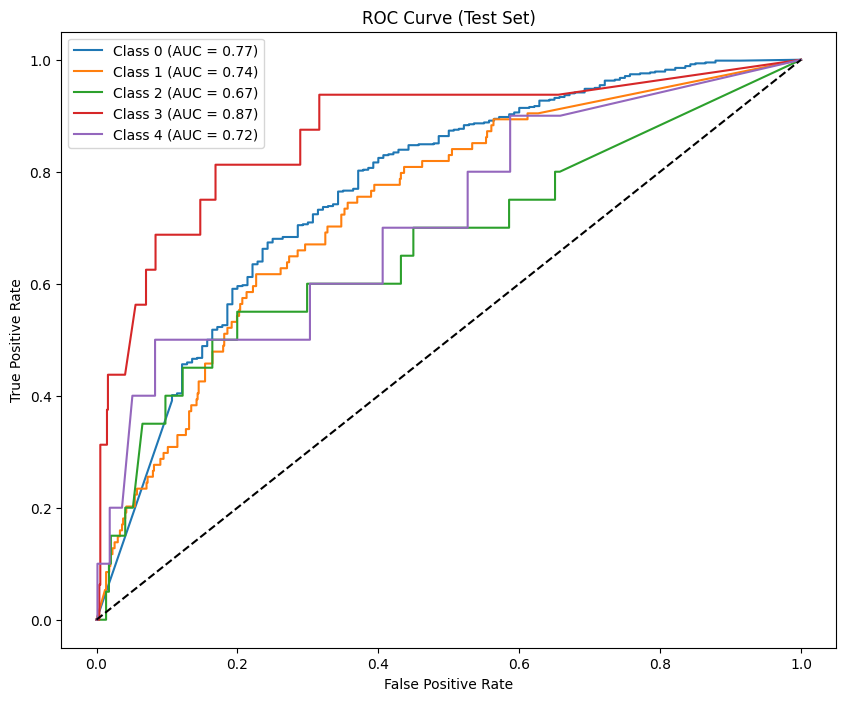

Train F1 (calibrated): [0.8635628  0.63230088 0.         0.         0.25      ] | Test F1 (calibrated): [0.90702948 0.27972028 0.         0.         0.        ]
Train Precision (calibrated): [0.76197276 0.97809719 0.         0.         0.8       ] | Test Precision (calibrated): [0.84865629 0.40816327 0.         0.         0.        ]
Train Recall (calibrated): [0.99640908 0.46714613 0.         0.         0.14814815] | Test Recall (calibrated): [0.97402597 0.21276596 0.         0.         0.        ]
Train Accuracy (calibrated): 0.7918637653736992 | Test Accuracy (calibrated): 0.8201058201058201
Train Auc (calibrated): 0.9492085077739782 | Test Auc (calibrated): 0.7537791336643628
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase1.csv

=== Permutation Importance for phase phase1 ===


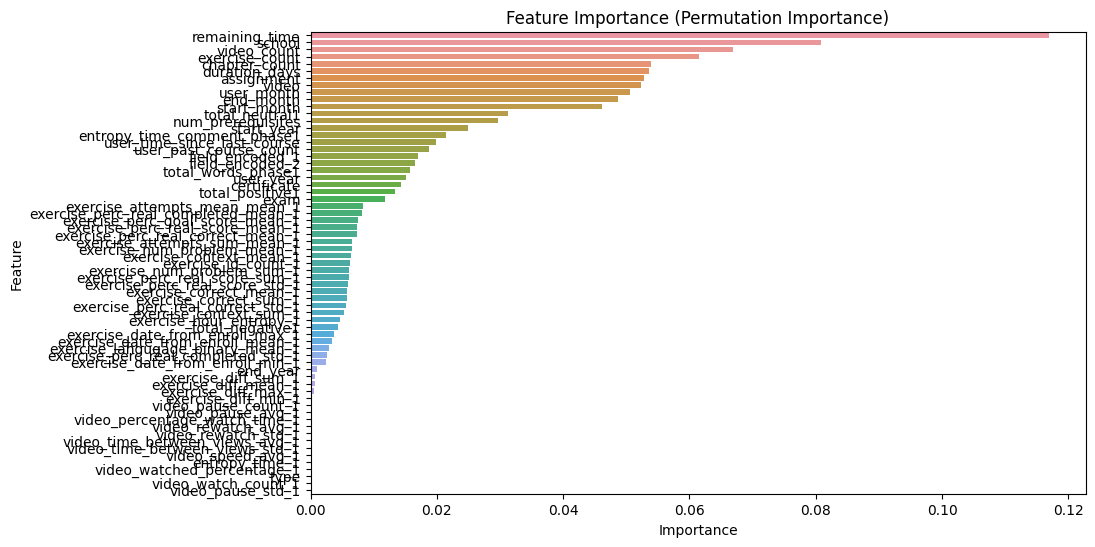


=== Lasso Feature Selection for phase phase1 ===


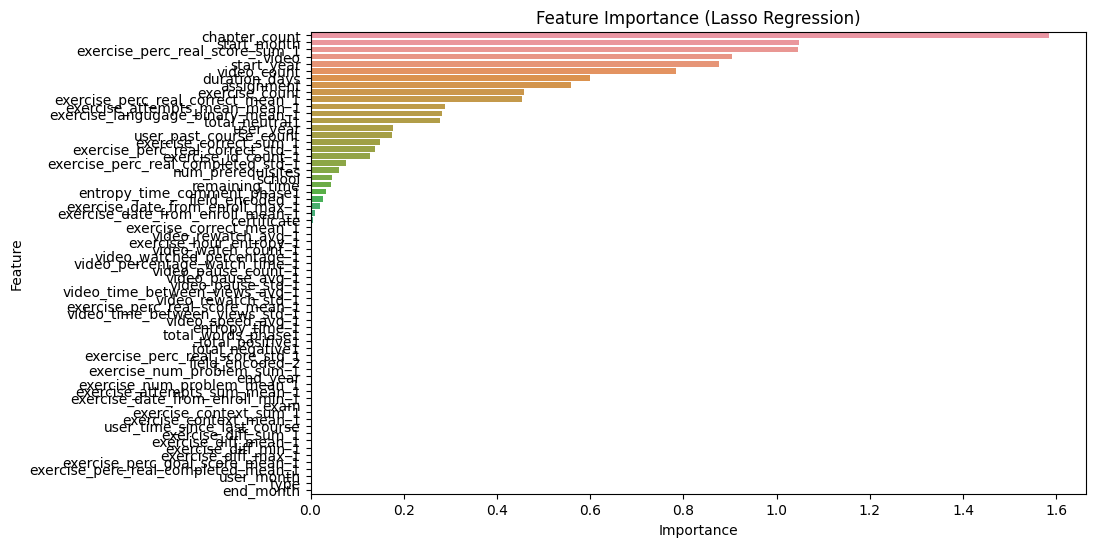

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Columns: 113 entries, user_id to label_encoded
dtypes: float64(100), int64(9), object(4)
memory usage: 7.4+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Parameters for phase phase2: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'euclidean'} ===

=== Evaluation for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.87982132 0.7046542  0.57217848 0.60096154 0.73333333]
Precision (per class): [0.85052317 0.75174014 0.7218543  0.67204301 0.62857143]
Recall (per class): [0.91120996 0.66311912 0.47391304 0.54347826 0.88      ]
Accuracy: 0.8185540477304633
AUC (One-vs-Rest): 0.9324465782451414

====== Test Set ======
F1 Score (per class): [0.91344668 0.33986928 0.         0.         0.        ]
Precision (per class): [0.86277372 0.42622951 0.         0.         0.        ]
Recall (per class): [0.97044335 0.2826087  0.         0.         0.        ]
Accuracy: 0.8270

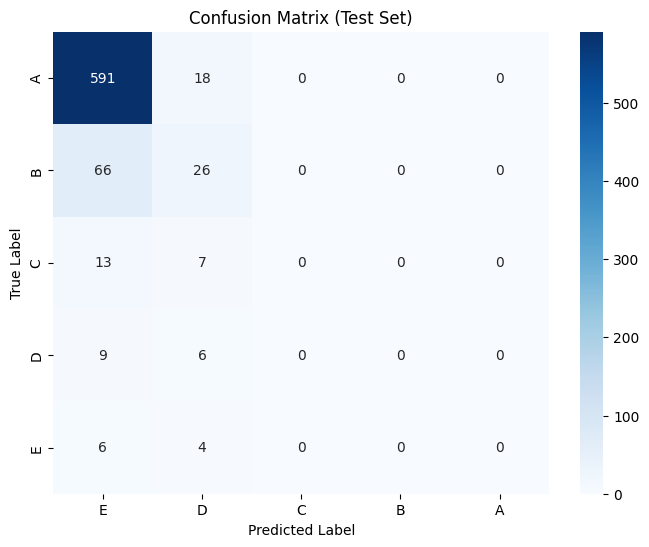

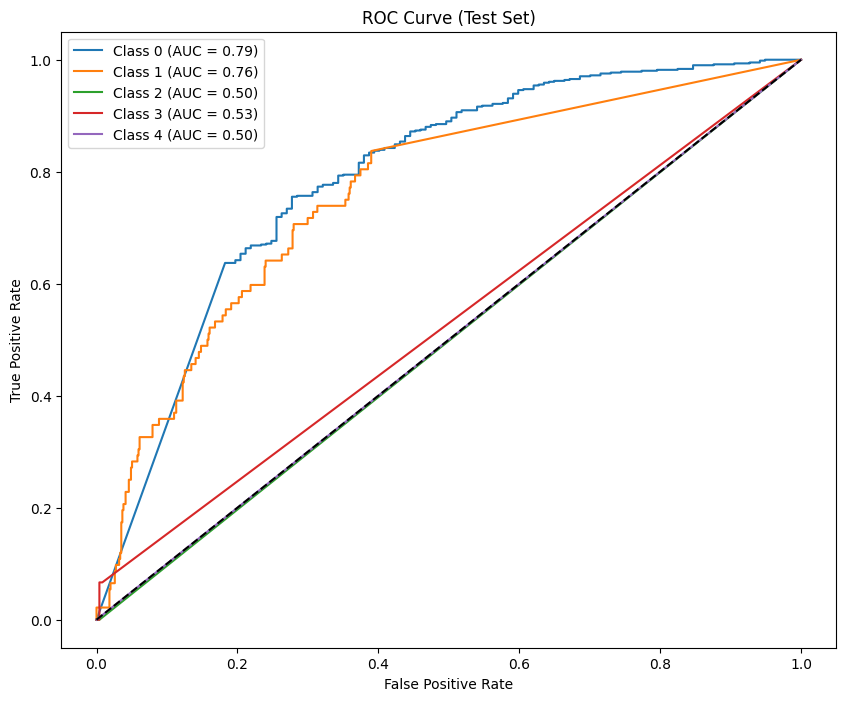

Train F1: [0.87982132 0.7046542  0.57217848 0.60096154 0.73333333] | Test F1: [0.91344668 0.33986928 0.         0.         0.        ]
Train Precision: [0.85052317 0.75174014 0.7218543  0.67204301 0.62857143] | Test Precision: [0.86277372 0.42622951 0.         0.         0.        ]
Train Recall: [0.91120996 0.66311912 0.47391304 0.54347826 0.88      ] | Test Recall: [0.97044335 0.2826087  0.         0.         0.        ]
Train Accuracy: 0.8185540477304633 | Test Accuracy: 0.8270777479892761
Train Auc: 0.9324465782451414 | Test Auc: 0.6154968304249826
Test predictions saved as test_results_minmax_f1_macro_phase2.csv

=== Evaluation after calibration for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.83819906 0.47307812 0.         0.         0.33333333]
Precision (per class): [0.72211501 0.98701299 0.         0.         1.        ]
Recall (per class): [0.99875445 0.31109292 0.         0.         0.2       ]
Accuracy: 0.7461394478240524
AUC (One-vs-Rest): 0.944837402

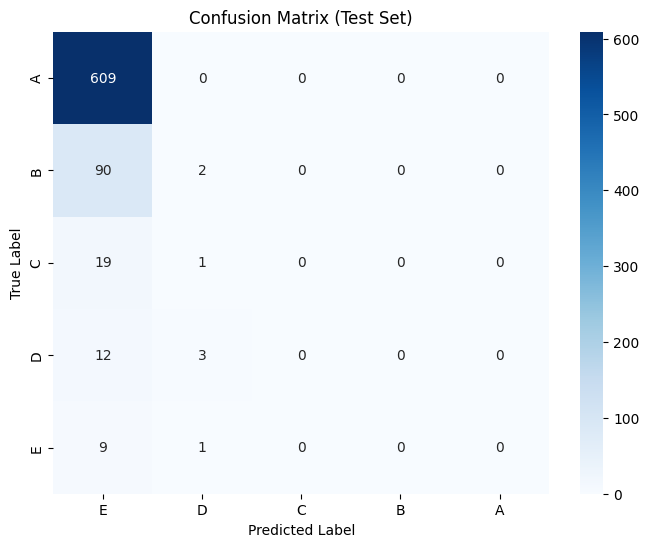

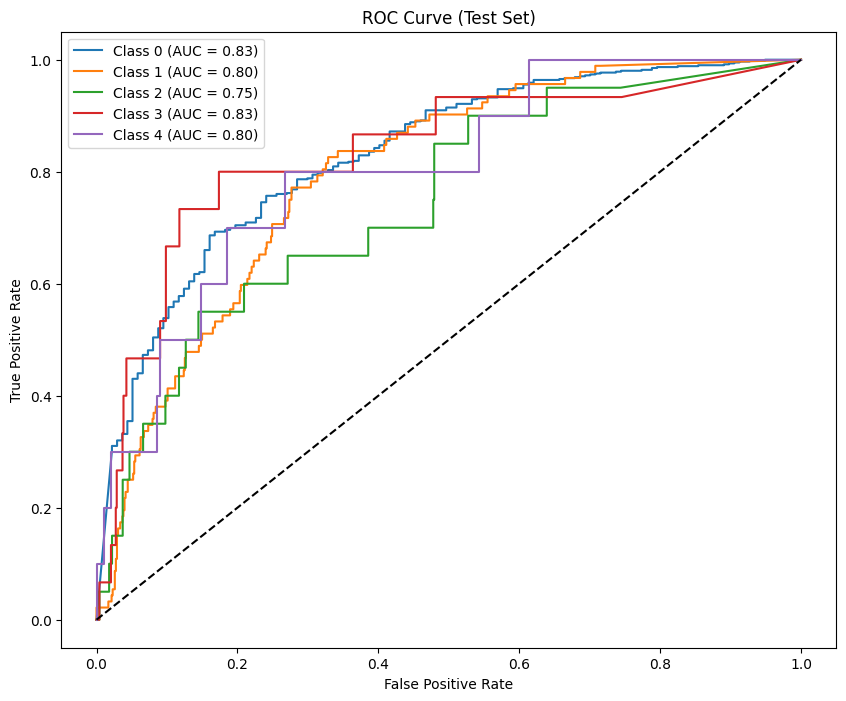

Train F1 (calibrated): [0.83819906 0.47307812 0.         0.         0.33333333] | Test F1 (calibrated): [0.90356083 0.04040404 0.         0.         0.        ]
Train Precision (calibrated): [0.72211501 0.98701299 0.         0.         1.        ] | Test Precision (calibrated): [0.8240866  0.28571429 0.         0.         0.        ]
Train Recall (calibrated): [0.99875445 0.31109292 0.         0.         0.2       ] | Test Recall (calibrated): [1.         0.02173913 0.         0.         0.        ]
Train Accuracy (calibrated): 0.7461394478240524 | Test Accuracy (calibrated): 0.8190348525469169
Train Auc (calibrated): 0.9448374026370198 | Test Auc (calibrated): 0.8024373547352475
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase2.csv

=== Permutation Importance for phase phase2 ===


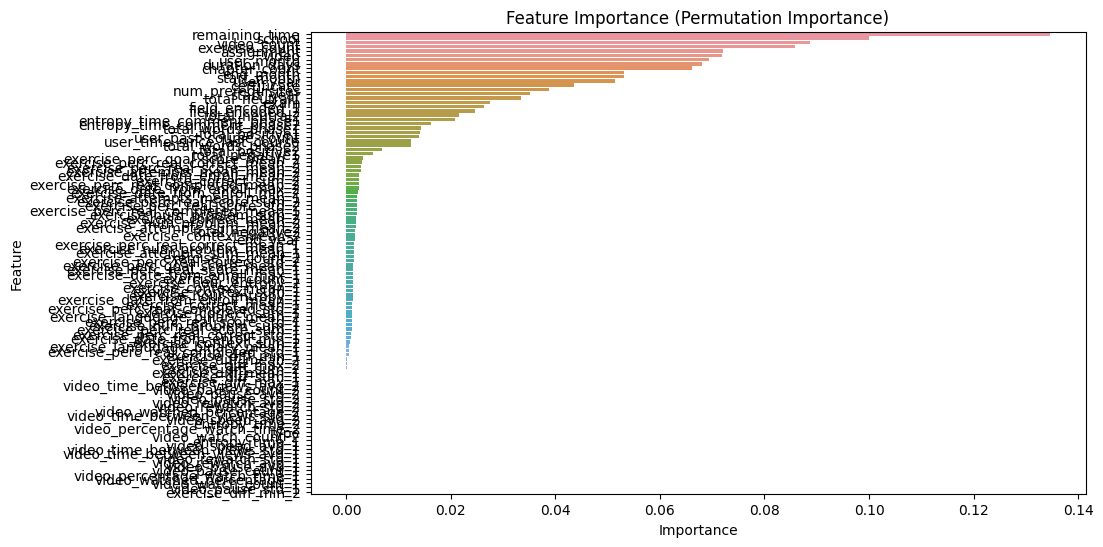


=== Lasso Feature Selection for phase phase2 ===


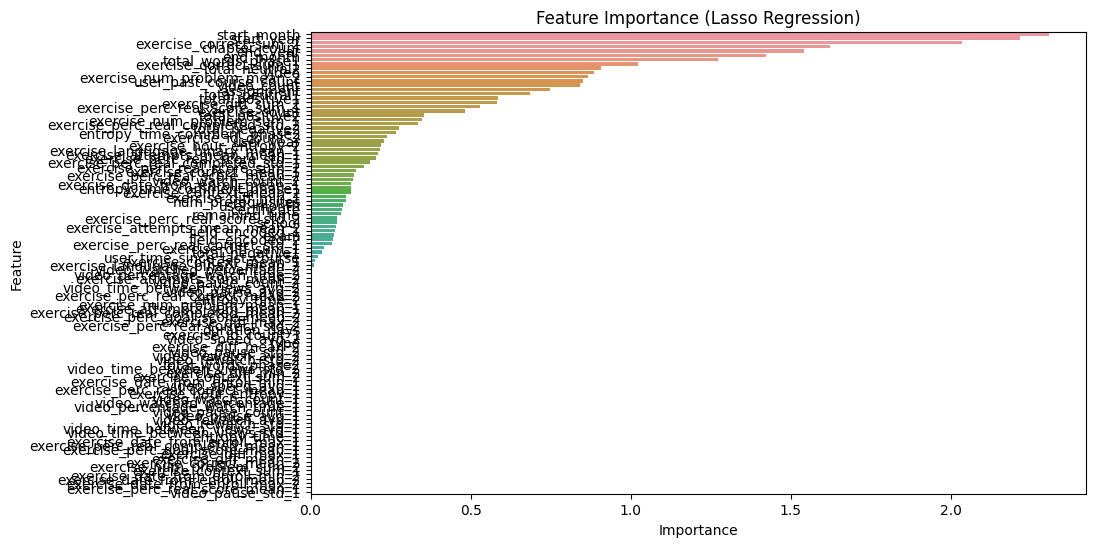

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Columns: 156 entries, user_id to label_encoded
dtypes: float64(143), int64(9), object(4)
memory usage: 9.3+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.3s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.3s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   2.2s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   2.0s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   2.0s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   2.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   2.1s
[CV] END ..metric=ma

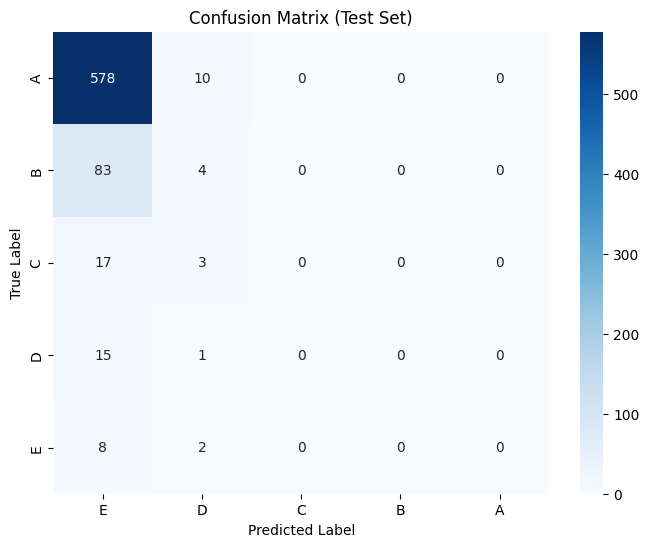

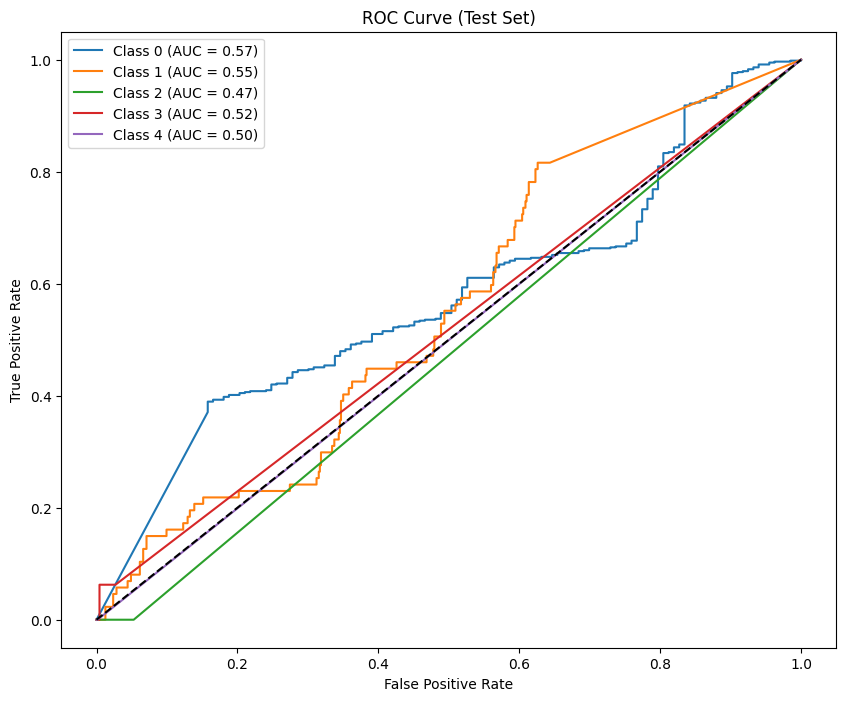

Train F1: [0.88586227 0.73199635 0.60625    0.61971831 0.69565217] | Test F1: [0.89681924 0.07476636 0.         0.         0.        ]
Train Precision: [0.87099208 0.75469925 0.76377953 0.60273973 0.59259259] | Test Precision: [0.82453638 0.2        0.         0.         0.        ]
Train Recall: [0.90124902 0.71061947 0.50259067 0.63768116 0.84210526] | Test Recall: [0.9829932  0.04597701 0.         0.         0.        ]
Train Accuracy: 0.829040112777137 | Test Accuracy: 0.8072122052704577
Train Auc: 0.9414668280578112 | Test Auc: 0.5234337416540417
Test predictions saved as test_results_minmax_f1_macro_phase3.csv

=== Evaluation after calibration for phase phase3 ===

====== Train Set ======
F1 Score (per class): [0.85299516 0.56539552 0.         0.20779221 0.34782609]
Precision (per class): [0.74497231 0.98247536 0.         1.         1.        ]
Recall (per class): [0.99765808 0.39690265 0.         0.11594203 0.21052632]
Accuracy: 0.773676790977829
AUC (One-vs-Rest): 0.94755534456

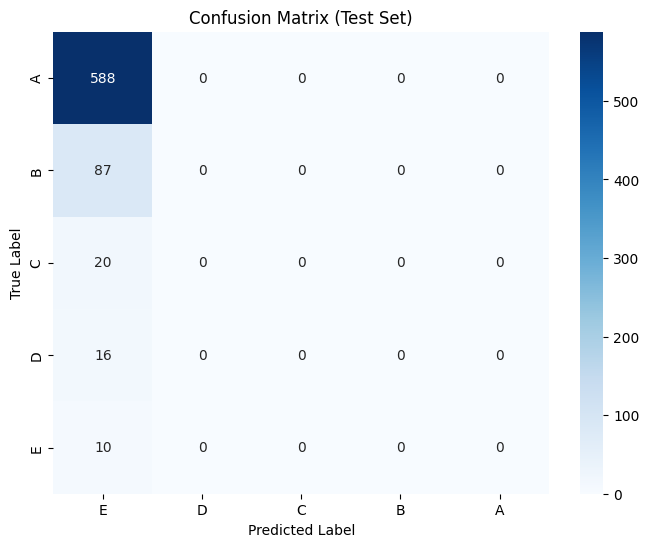

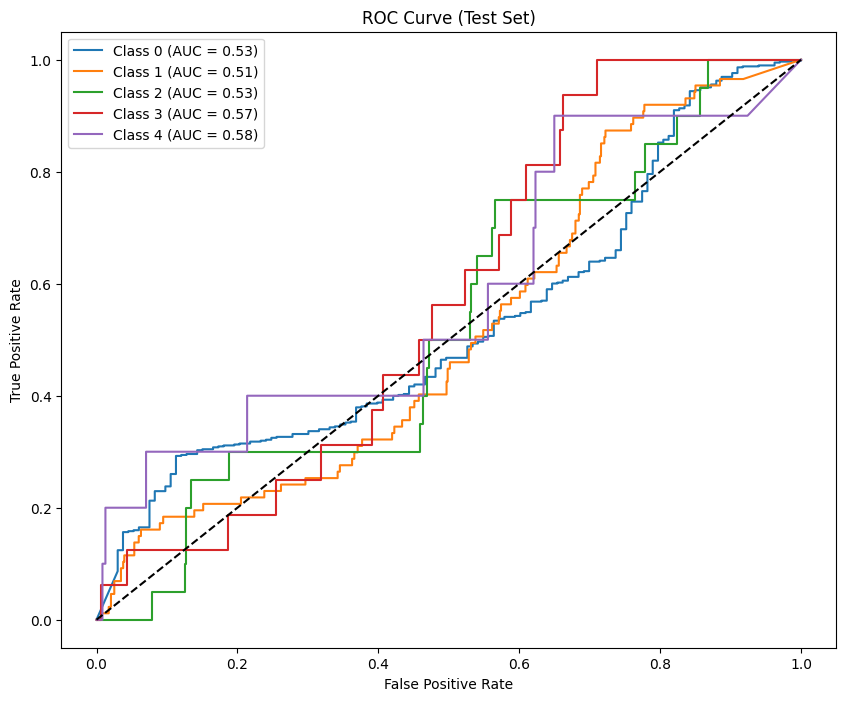

Train F1 (calibrated): [0.85299516 0.56539552 0.         0.20779221 0.34782609] | Test F1 (calibrated): [0.89839572 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.74497231 0.98247536 0.         1.         1.        ] | Test Precision (calibrated): [0.81553398 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99765808 0.39690265 0.         0.11594203 0.21052632] | Test Recall (calibrated): [1. 0. 0. 0. 0.]
Train Accuracy (calibrated): 0.773676790977829 | Test Accuracy (calibrated): 0.8155339805825242
Train Auc (calibrated): 0.9475553445687112 | Test Auc (calibrated): 0.5438876475341305
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase3.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Columns: 199 entries, user_id to label_encoded
dtypes: float64(186), int64(9), object(4)
memory usage: 8.1+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...metric=

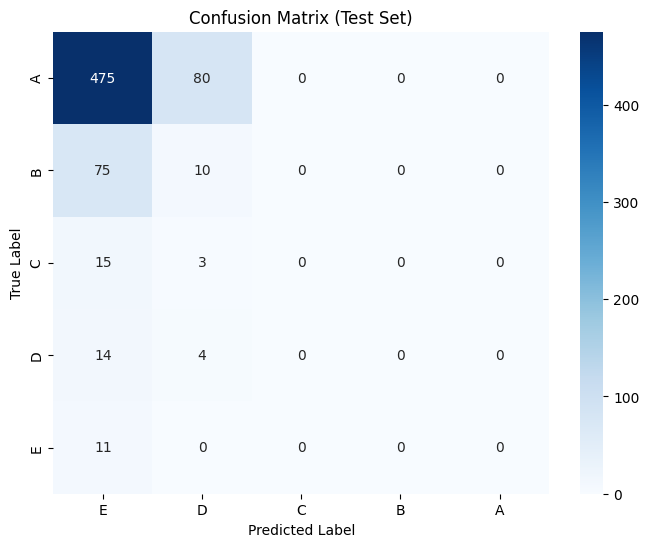

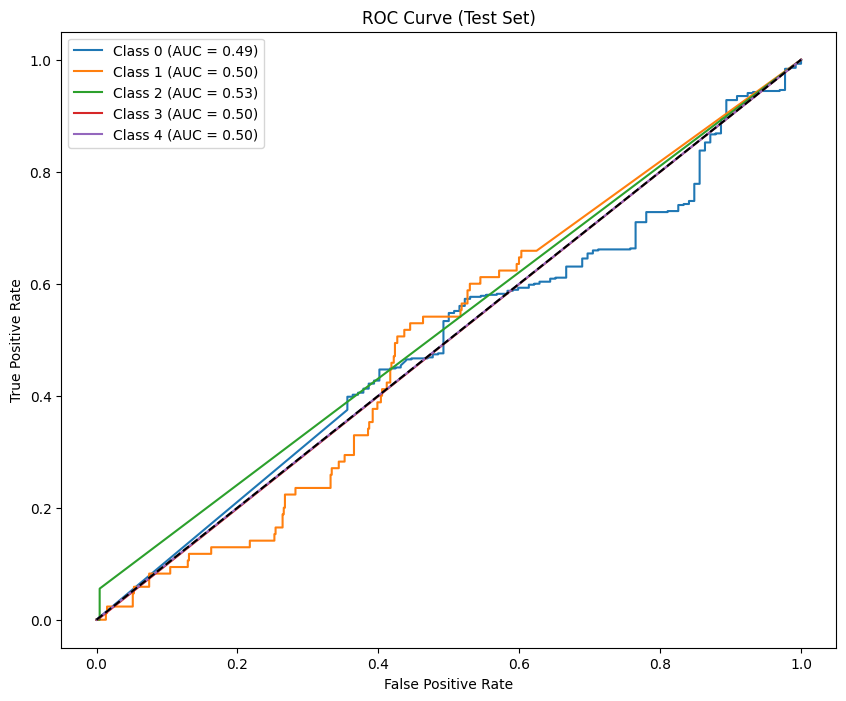

Train F1: [0.89518805 0.75992063 0.66233766 0.69784173 0.68421053] | Test F1: [0.82969432 0.10989011 0.         0.         0.        ]
Train Precision: [0.86899329 0.79680999 0.96226415 0.81512605 0.54166667] | Test Precision: [0.80508475 0.10309278 0.         0.         0.        ]
Train Recall: [0.92301112 0.72629583 0.5049505  0.61006289 0.92857143] | Test Recall: [0.85585586 0.11764706 0.         0.         0.        ]
Train Accuracy: 0.8478463546522469 | Test Accuracy: 0.7059679767103348
Train Auc: 0.9399606995626859 | Test Auc: 0.5034912414332153
Test predictions saved as test_results_minmax_f1_macro_phase4.csv

=== Evaluation after calibration for phase phase4 ===

====== Train Set ======
F1 Score (per class): [0.87226323 0.63881857 0.30252101 0.59030837 0.35294118]
Precision (per class): [0.77708426 0.9606599  1.         0.98529412 1.        ]
Recall (per class): [0.99401198 0.47850822 0.17821782 0.42138365 0.21428571]
Accuracy: 0.8075703897072534
AUC (One-vs-Rest): 0.944315559

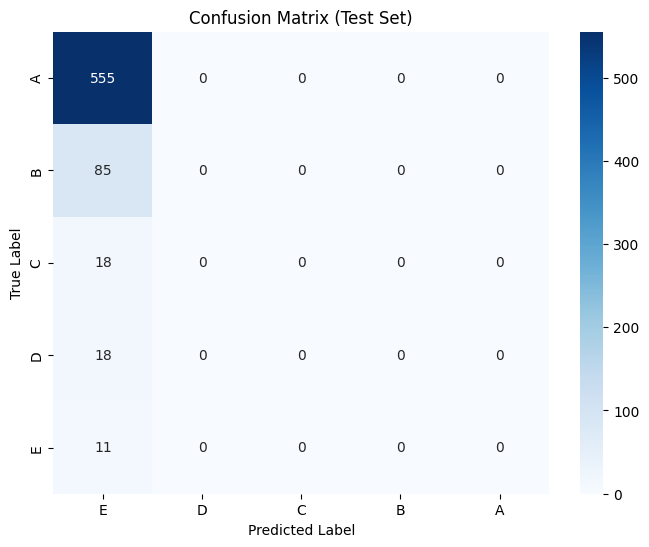

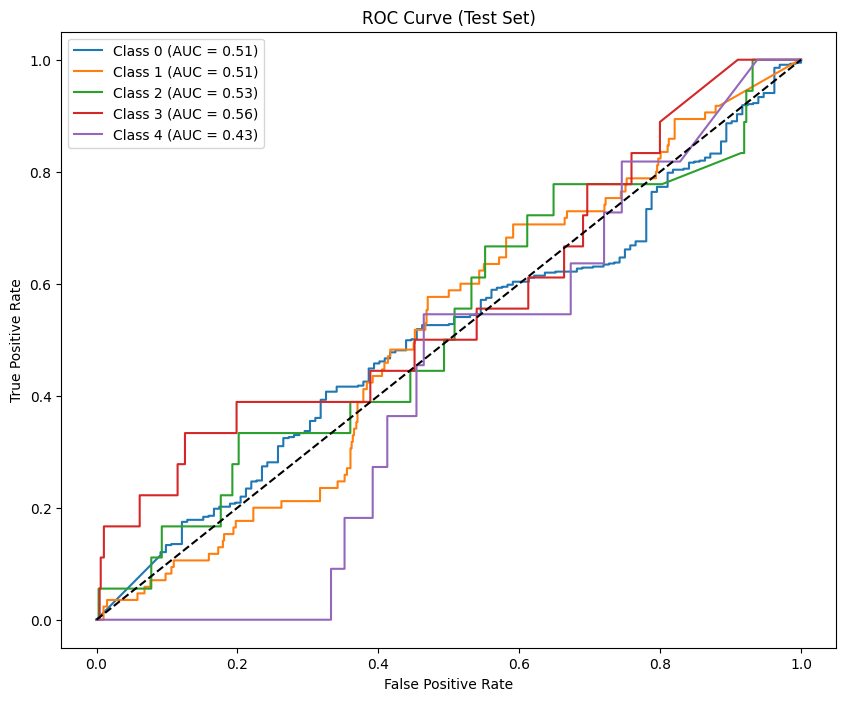

Train F1 (calibrated): [0.87226323 0.63881857 0.30252101 0.59030837 0.35294118] | Test F1 (calibrated): [0.89371981 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.77708426 0.9606599  1.         0.98529412 1.        ] | Test Precision (calibrated): [0.80786026 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99401198 0.47850822 0.17821782 0.42138365 0.21428571] | Test Recall (calibrated): [1. 0. 0. 0. 0.]
Train Accuracy (calibrated): 0.8075703897072534 | Test Accuracy (calibrated): 0.8078602620087336
Train Auc (calibrated): 0.9443155597623145 | Test Auc (calibrated): 0.5072178916960149
Calibrated predictions saved as test_results_calibrate_minmax_f1_macro_phase4.csv


In [16]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    process_phase(phase, metric='f1_macro')

# 4. Log

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def process_phase(phase, scale='log', metric='accuracy'):
    # Đọc dữ liệu
    X_train, y_train, X_test, y_test = load_data(phase)

    # Scale dữ liệu
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaler_type=scale)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Thiết lập StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Định nghĩa mô hình KNN
    model = KNeighborsClassifier()

    # Tham số tìm kiếm cho KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=skf,
        scoring=metric,
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    # Huấn luyện mô hình
    randomized_search.fit(X_train_scaled, y_train)

    # In tham số tốt nhất
    best_params = randomized_search.best_params_
    print(f"\n=== Best Parameters for phase {phase}: {best_params} ===")

    # Đánh giá mô hình gốc
    print(f"\n=== Evaluation for phase {phase} ===")
    evaluation_results = evaluate_model(
        randomized_search.best_estimator_,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # Lấy các kết quả từ evaluation_results
    train_results = evaluation_results['train']
    test_results = evaluation_results['test']

    # In kết quả
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()}: {train_results[metric_name]} | Test {metric_name.capitalize()}: {test_results[metric_name]}")

    # Lưu kết quả dự đoán
    y_pred = randomized_search.best_estimator_.predict(X_test_scaled)
    results_df = X_test.copy()
    results_df['True_Label'] = y_test
    results_df['Predicted_Label'] = y_pred
    results_filename = f"test_results_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"Test predictions saved as {results_filename}")

    # Calibrate model (sử dụng Platt scaling với KNN)
    calibrate_train_model = calibrate_model(randomized_search.best_estimator_, X_train_scaled, y_train)

    # Đánh giá mô hình sau calibrate
    print(f"\n=== Evaluation after calibration for phase {phase} ===")
    evaluation_results_cal = evaluate_model(
        calibrate_train_model,
        X_train_scaled, y_train,
        X_test_scaled, y_test
    )

    # In kết quả sau hiệu chuẩn
    train_results_cal = evaluation_results_cal['train']
    test_results_cal = evaluation_results_cal['test']
    for metric_name in ['f1', 'precision', 'recall', 'accuracy', 'auc']:
        print(f"Train {metric_name.capitalize()} (calibrated): {train_results_cal[metric_name]} | Test {metric_name.capitalize()} (calibrated): {test_results_cal[metric_name]}")

    # Lưu kết quả dự đoán sau calibrate
    y_calibrate_pred = calibrate_train_model.predict(X_test_scaled)
    results_df['Calibrated_Predicted_Label'] = y_calibrate_pred
    results_calibrate_filename = f"test_results_calibrate_{scale}_{metric}_{phase}.csv"
    results_df.to_csv(results_calibrate_filename, index=False)
    print(f"Calibrated predictions saved as {results_calibrate_filename}")

    # Nếu phase 1 hoặc 2 → chạy chọn feature
    if int(phase[-1]) <= 2:
        print(f"\n=== Permutation Importance for phase {phase} ===")
        perm_importance = plot_permutation_importance(randomized_search.best_estimator_, X_train_scaled, y_train)

        print(f"\n=== Lasso Feature Selection for phase {phase} ===")
        lasso_importance = lasso_feature_selection(X_train_scaled, y_train)

        # model_with_best_params = KNeighborsClassifier(**best_params)
        # print("\n=== Boruta Trick ===")
        # important_features = boruta_trick(model_with_best_params, X_train_scaled, y_train)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   user_id                              10570 non-null  object 
 1   school                               6715 non-null   object 
 2   course_id                            10570 non-null  object 
 3   field_encoded_1                      10570 non-null  int64  
 4   field_encoded_2                      10570 non-null  int64  
 5   start_year                           10570 non-null  float64
 6   start_month                          10570 non-null  float64
 7   end_year                             10570 non-null  float64
 8   end_month                            10570 non-null  float64
 9   user_year                            10570 non-null  float64
 10  user_month                           10570 non-null  float64
 11  video_count                 

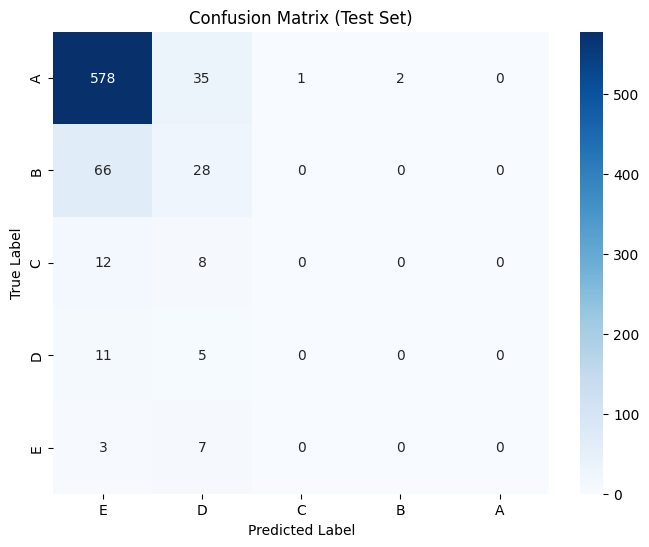

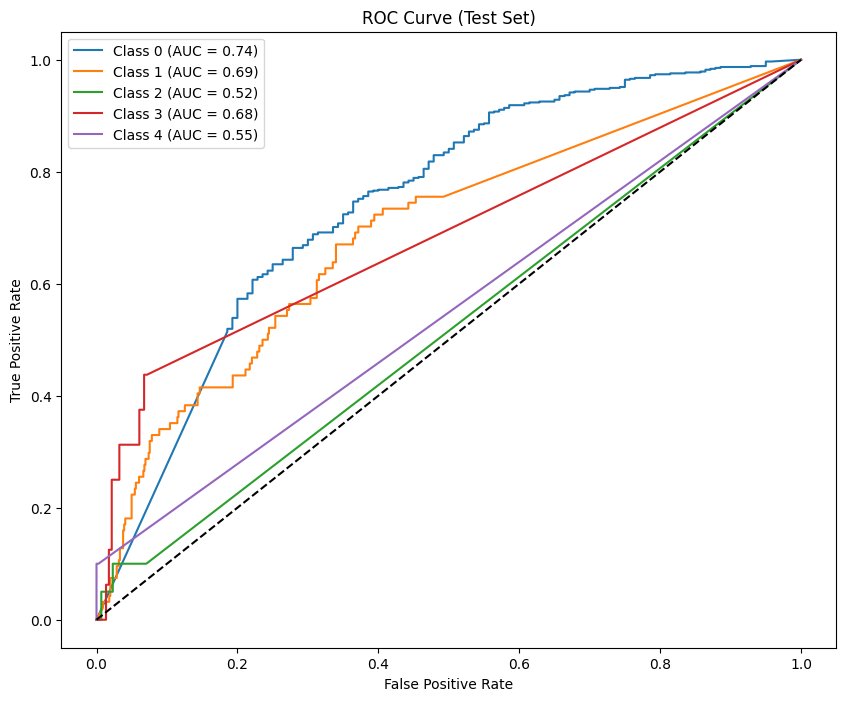

Train F1: [0.88604246 0.72883689 0.58852868 0.59481038 0.6557377 ] | Test F1: [0.89891135 0.31638418 0.         0.         0.        ]
Train Precision: [0.85965149 0.76934254 0.90076336 0.59839357 0.58823529] | Test Precision: [0.86268657 0.3373494  0.         0.         0.        ]
Train Recall: [0.91410514 0.69238313 0.43703704 0.59126984 0.74074074] | Test Recall: [0.93831169 0.29787234 0.         0.         0.        ]
Train Accuracy: 0.8296121097445601 | Test Accuracy: 0.8015873015873016
Train Auc: 0.9395421926443767 | Test Auc: 0.6366294480620839
Test predictions saved as test_results_log_f1_macro_phase1.csv

=== Evaluation after calibration for phase phase1 ===

====== Train Set ======
F1 Score (per class): [0.86379482 0.63395225 0.         0.         0.13333333]
Precision (per class): [0.76225005 0.97883959 0.         0.         0.66666667]
Recall (per class): [0.99655271 0.46878065 0.         0.         0.07407407]
Accuracy: 0.7922421948912015
AUC (One-vs-Rest): 0.950593237834

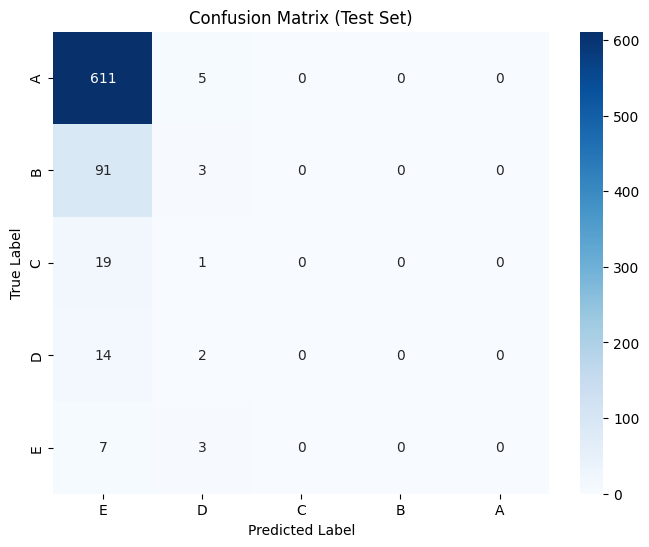

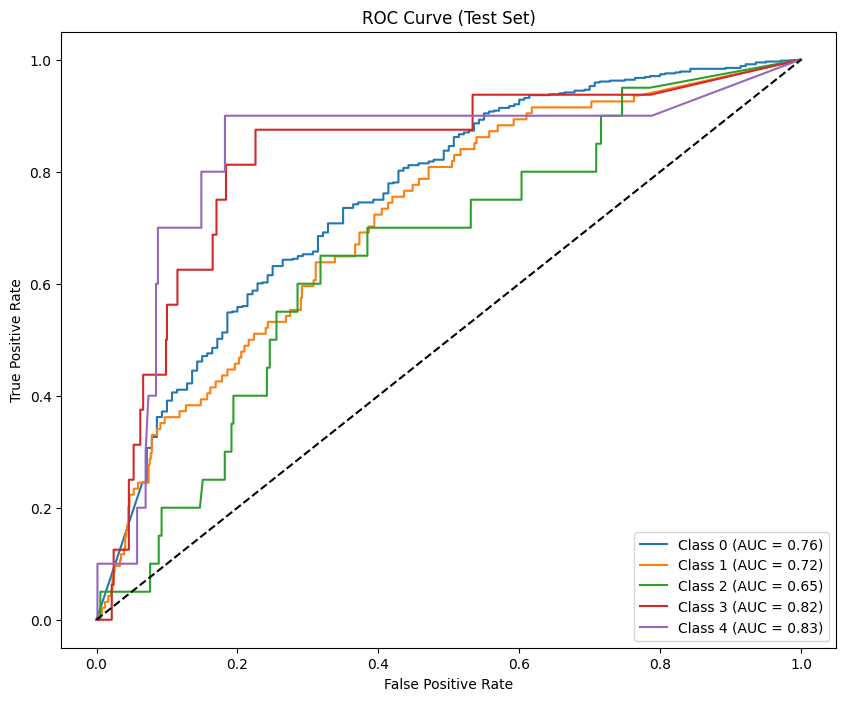

Train F1 (calibrated): [0.86379482 0.63395225 0.         0.         0.13333333] | Test F1 (calibrated): [0.89985272 0.05555556 0.         0.         0.        ]
Train Precision (calibrated): [0.76225005 0.97883959 0.         0.         0.66666667] | Test Precision (calibrated): [0.82345013 0.21428571 0.         0.         0.        ]
Train Recall (calibrated): [0.99655271 0.46878065 0.         0.         0.07407407] | Test Recall (calibrated): [0.99188312 0.03191489 0.         0.         0.        ]
Train Accuracy (calibrated): 0.7922421948912015 | Test Accuracy (calibrated): 0.8121693121693122
Train Auc (calibrated): 0.9505932378343985 | Test Auc (calibrated): 0.7571805545742458
Calibrated predictions saved as test_results_calibrate_log_f1_macro_phase1.csv

=== Permutation Importance for phase phase1 ===


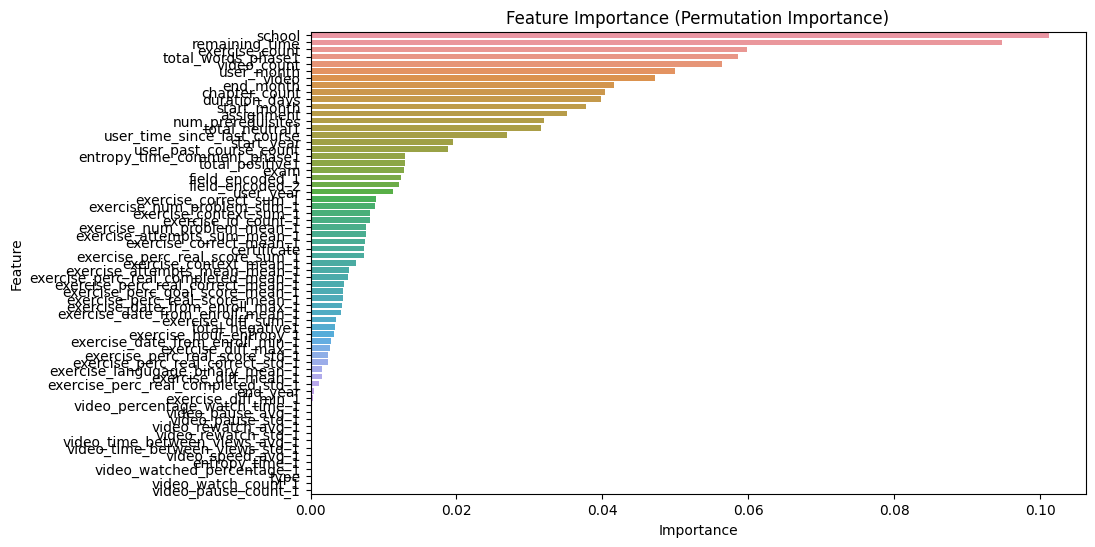


=== Lasso Feature Selection for phase phase1 ===


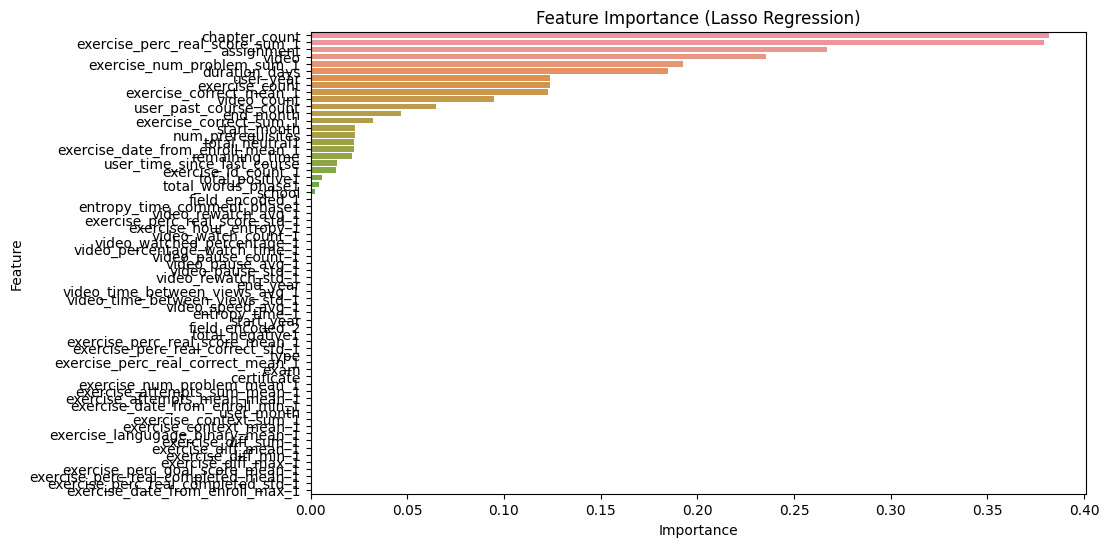

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Columns: 113 entries, user_id to label_encoded
dtypes: float64(100), int64(9), object(4)
memory usage: 7.4+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Parameters for phase phase2: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'} ===

=== Evaluation for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.87986957 0.70439704 0.56763926 0.59854015 0.73333333]
Precision (per class): [0.84968512 0.75220828 0.72789116 0.67955801 0.62857143]
Recall (per class): [0.91227758 0.66230045 0.46521739 0.53478261 0.88      ]
Accuracy: 0.8185540477304633
AUC (One-vs-Rest): 0.9337556796845838

====== Test Set ======
F1 Score (per class): [0.88074825 0.20125786 0.         0.         0.        ]
Precision (per class): [0.83827893 0.23880597 0.         0.         0.        ]
Recall (per class): [0.92775041 0.17391304 0.         0.         0.        ]
Accuracy: 0.7788

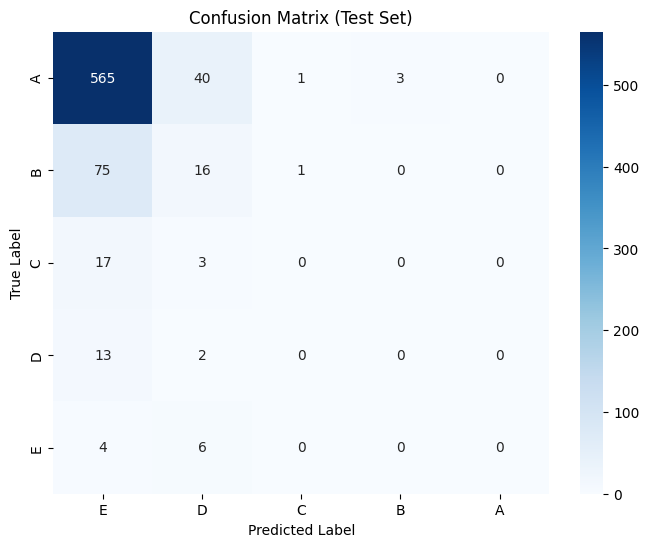

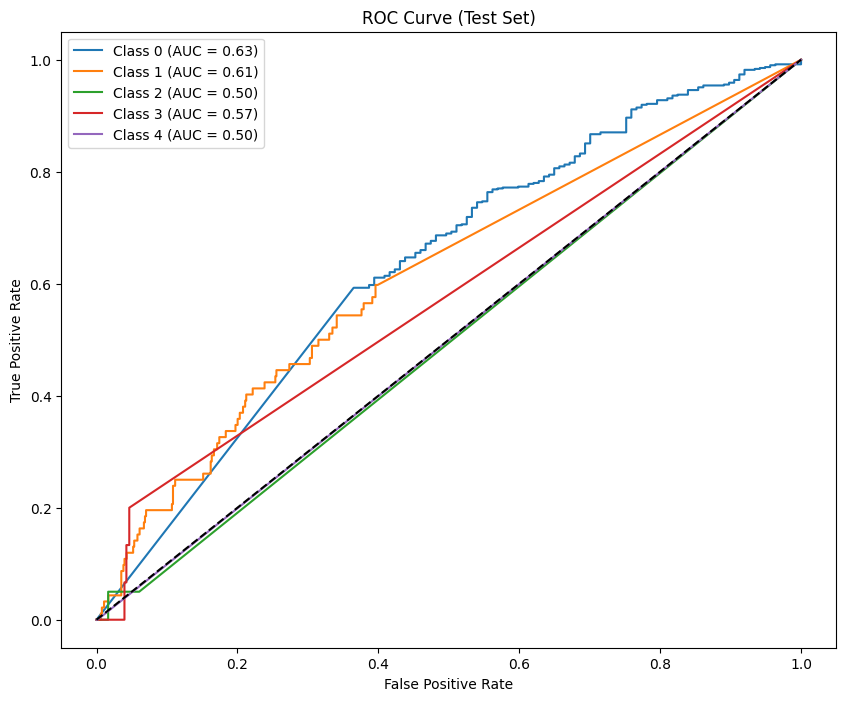

Train F1: [0.87986957 0.70439704 0.56763926 0.59854015 0.73333333] | Test F1: [0.88074825 0.20125786 0.         0.         0.        ]
Train Precision: [0.84968512 0.75220828 0.72789116 0.67955801 0.62857143] | Test Precision: [0.83827893 0.23880597 0.         0.         0.        ]
Train Recall: [0.91227758 0.66230045 0.46521739 0.53478261 0.88      ] | Test Recall: [0.92775041 0.17391304 0.         0.         0.        ]
Train Accuracy: 0.8185540477304633 | Test Accuracy: 0.7788203753351206
Train Auc: 0.9337556796845838 | Test Auc: 0.562466107334063
Test predictions saved as test_results_log_f1_macro_phase2.csv

=== Evaluation after calibration for phase phase2 ===

====== Train Set ======
F1 Score (per class): [0.84068609 0.49262899 0.         0.         0.27586207]
Precision (per class): [0.72590868 0.98646986 0.         0.         1.        ]
Recall (per class): [0.99857651 0.3282849  0.         0.         0.16      ]
Accuracy: 0.7508189050070192
AUC (One-vs-Rest): 0.9451782125712

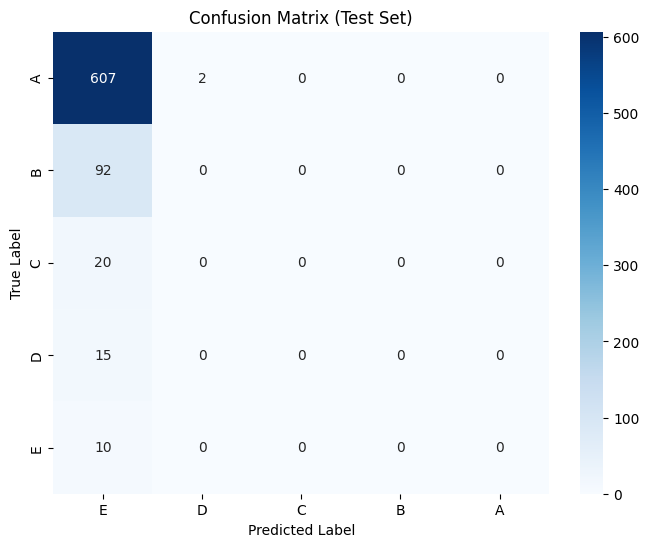

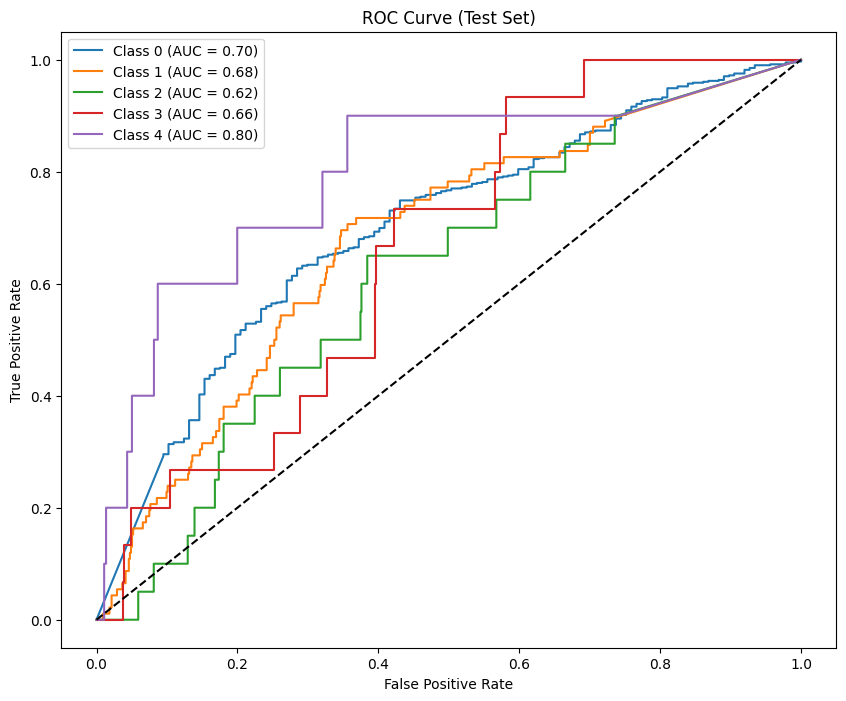

Train F1 (calibrated): [0.84068609 0.49262899 0.         0.         0.27586207] | Test F1 (calibrated): [0.89726534 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.72590868 0.98646986 0.         0.         1.        ] | Test Precision (calibrated): [0.81586022 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99857651 0.3282849  0.         0.         0.16      ] | Test Recall (calibrated): [0.99671593 0.         0.         0.         0.        ]
Train Accuracy (calibrated): 0.7508189050070192 | Test Accuracy (calibrated): 0.8136729222520107
Train Auc (calibrated): 0.9451782125712466 | Test Auc (calibrated): 0.6891837516539298
Calibrated predictions saved as test_results_calibrate_log_f1_macro_phase2.csv

=== Permutation Importance for phase phase2 ===


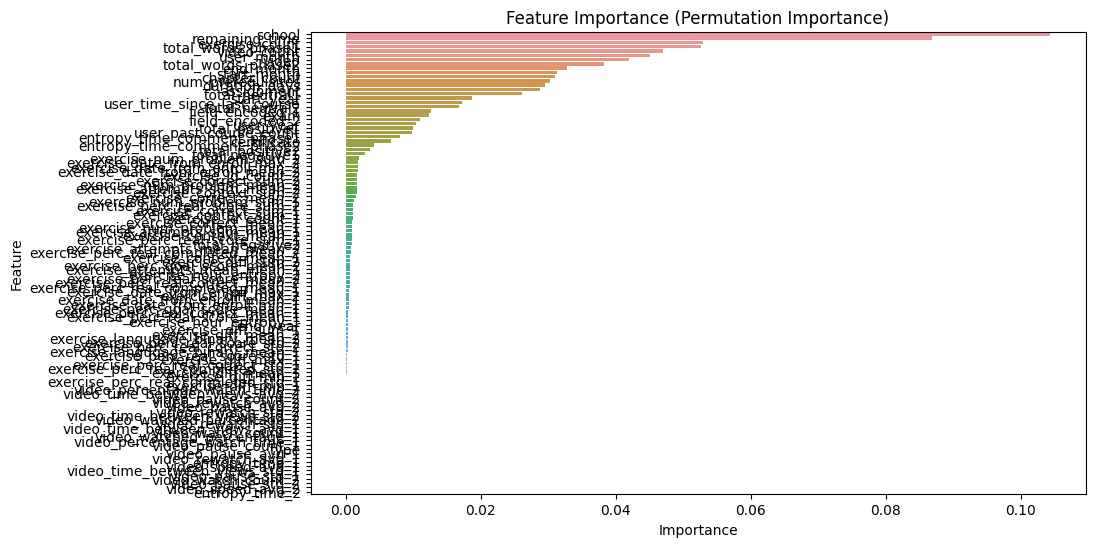


=== Lasso Feature Selection for phase phase2 ===


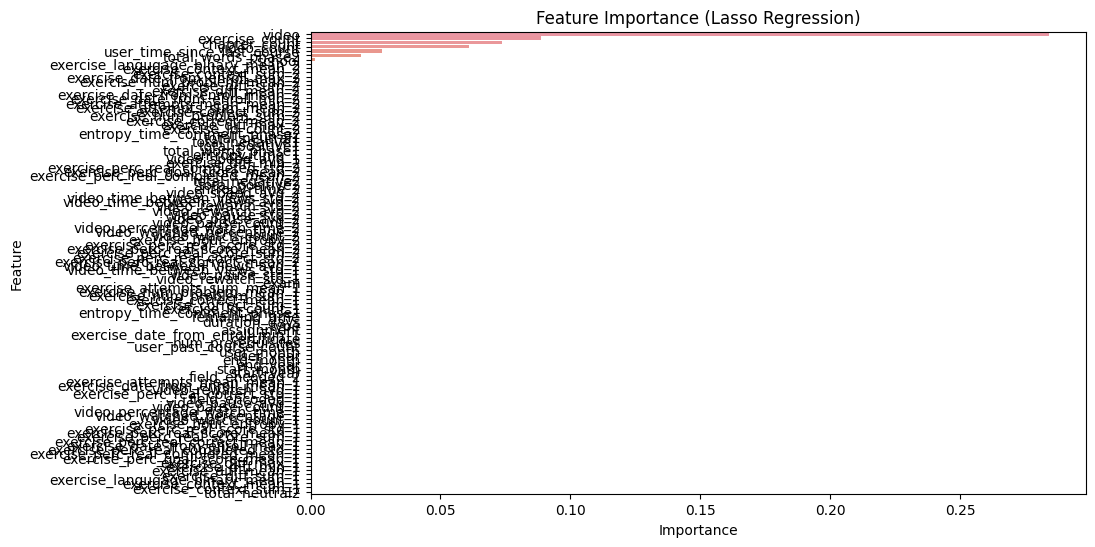

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Columns: 156 entries, user_id to label_encoded
dtypes: float64(143), int64(9), object(4)
memory usage: 9.3+ MB
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Parameters for phase phase3: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'} ===

=== Evaluation for phase phase3 ===

====== Train Set ======
F1 Score (per class): [0.88586227 0.73199635 0.60625    0.61971831 0.69565217]
Precision (per class): [0.87099208 0.75469925 0.76377953 0.60273973 0.59259259]
Recall (per class): [0.90124902 0.71061947 0.50259067 0.63768116 0.84210526]
Accuracy: 0.829040112777137
AUC (One-vs-Rest): 0.9414668280578112

====== Test Set ======
F1 Score (per class): [0.8672     0.07092199 0.         0.         0.        ]
Precision (per class): [0.81873112 0.09259259 0.         0.         0.        ]
Recall (per class): [0.92176871 0.05747126 0.         0.         0.        ]
Accuracy: 0.75866

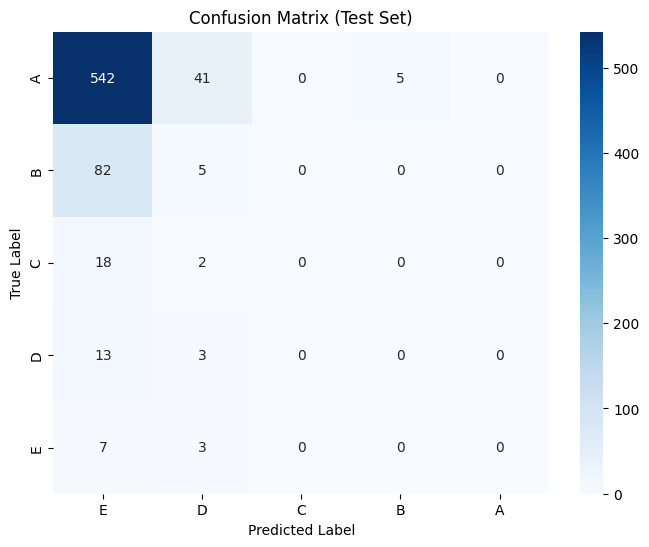

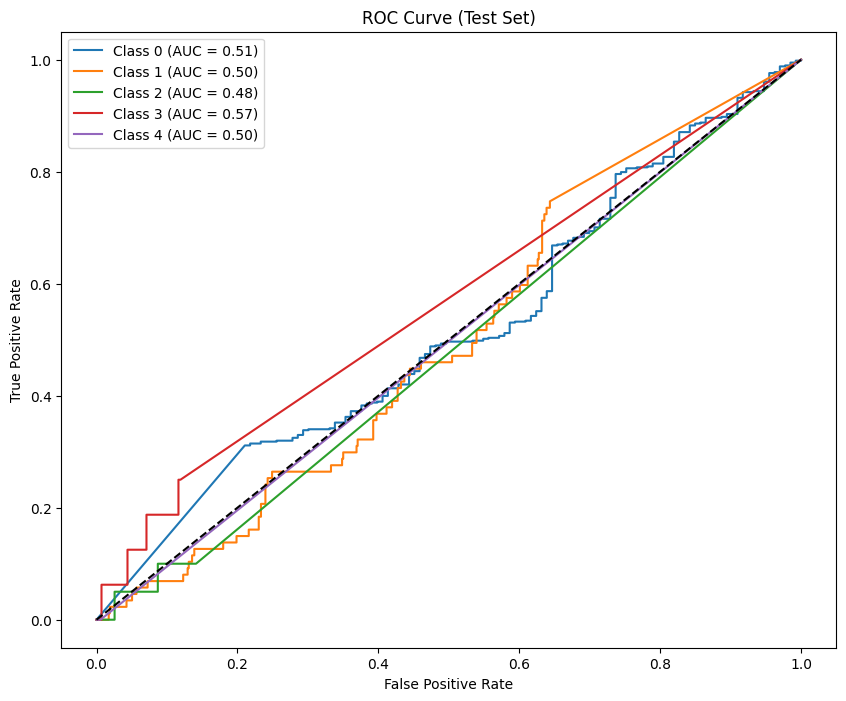

Train F1: [0.88586227 0.73199635 0.60625    0.61971831 0.69565217] | Test F1: [0.8672     0.07092199 0.         0.         0.        ]
Train Precision: [0.87099208 0.75469925 0.76377953 0.60273973 0.59259259] | Test Precision: [0.81873112 0.09259259 0.         0.         0.        ]
Train Recall: [0.90124902 0.71061947 0.50259067 0.63768116 0.84210526] | Test Recall: [0.92176871 0.05747126 0.         0.         0.        ]
Train Accuracy: 0.829040112777137 | Test Accuracy: 0.7586685159500693
Train Auc: 0.9414668280578112 | Test Auc: 0.5119492636595409
Test predictions saved as test_results_log_f1_macro_phase3.csv

=== Evaluation after calibration for phase phase3 ===

====== Train Set ======
F1 Score (per class): [0.8542067 0.5748278 0.        0.16      0.4      ]
Precision (per class): [0.7468225  0.98286938 0.         1.         0.83333333]
Recall (per class): [0.99765808 0.40619469 0.         0.08695652 0.26315789]
Accuracy: 0.7757272843778034
AUC (One-vs-Rest): 0.9486133895929074



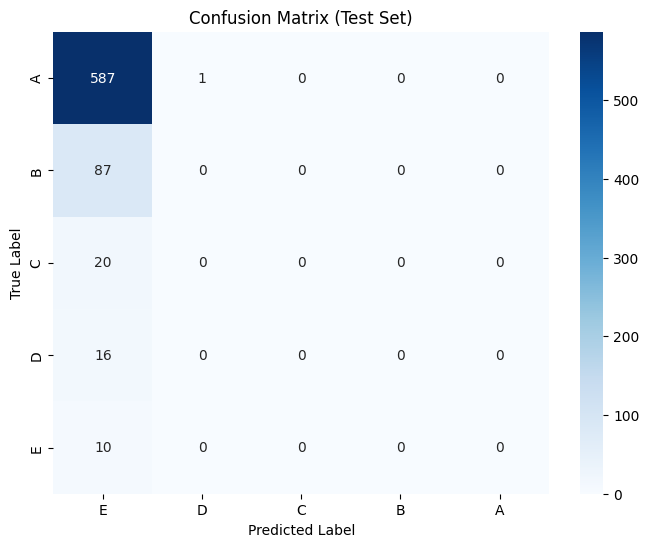

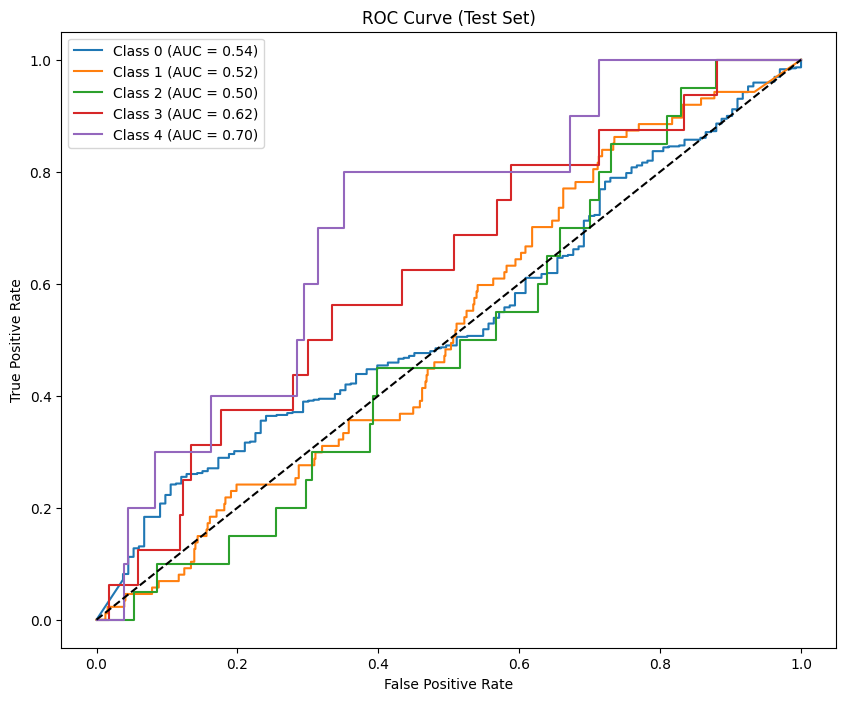

Train F1 (calibrated): [0.8542067 0.5748278 0.        0.16      0.4      ] | Test F1 (calibrated): [0.89755352 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.7468225  0.98286938 0.         1.         0.83333333] | Test Precision (calibrated): [0.81527778 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99765808 0.40619469 0.         0.08695652 0.26315789] | Test Recall (calibrated): [0.99829932 0.         0.         0.         0.        ]
Train Accuracy (calibrated): 0.7757272843778034 | Test Accuracy (calibrated): 0.8141470180305131
Train Auc (calibrated): 0.9486133895929074 | Test Auc (calibrated): 0.5761671066781157
Calibrated predictions saved as test_results_calibrate_log_f1_macro_phase3.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Columns: 199 entries, user_id to label_encoded
dtypes: float64(186), int64(9), object(4)
memory usage: 8.1+ MB
None
Fitting 5 folds for each of 10 candidates, tota

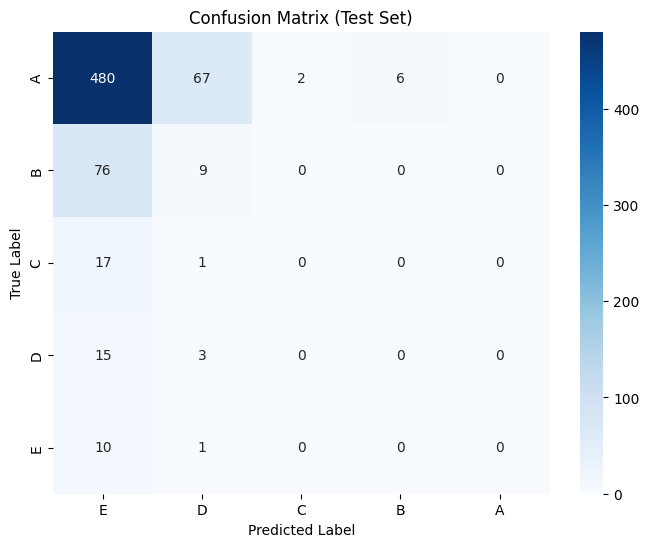

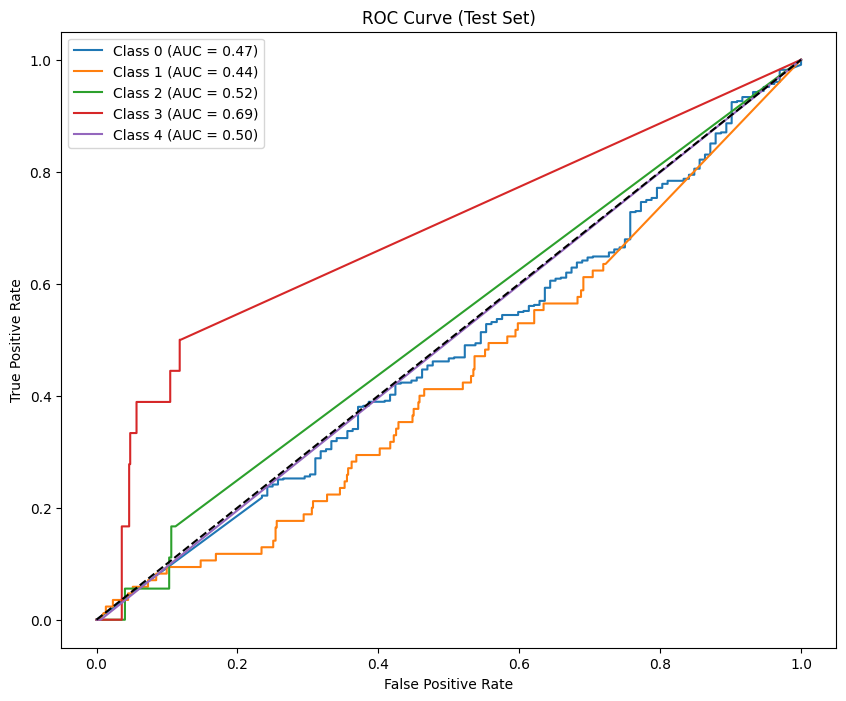

Train F1: [0.89535365 0.75873544 0.66666667 0.69343066 0.68421053] | Test F1: [0.83261058 0.10843373 0.         0.         0.        ]
Train Precision: [0.86679124 0.80112439 0.94545455 0.82608696 0.54166667] | Test Precision: [0.80267559 0.11111111 0.         0.         0.        ]
Train Recall: [0.92586256 0.72060683 0.51485149 0.59748428 0.92857143] | Test Recall: [0.86486486 0.10588235 0.         0.         0.        ]
Train Accuracy: 0.8478463546522469 | Test Accuracy: 0.7117903930131004
Train Auc: 0.9411825379573177 | Test Auc: 0.5241142886240068
Test predictions saved as test_results_log_f1_macro_phase4.csv

=== Evaluation after calibration for phase phase4 ===

====== Train Set ======
F1 Score (per class): [0.85546445 0.55620767 0.09433962 0.53456221 0.35294118]
Precision (per class): [0.74935678 0.97314376 1.         1.         1.        ]
Recall (per class): [0.99657827 0.38938053 0.04950495 0.36477987 0.21428571]
Accuracy: 0.7788551184038784
AUC (One-vs-Rest): 0.945425916075

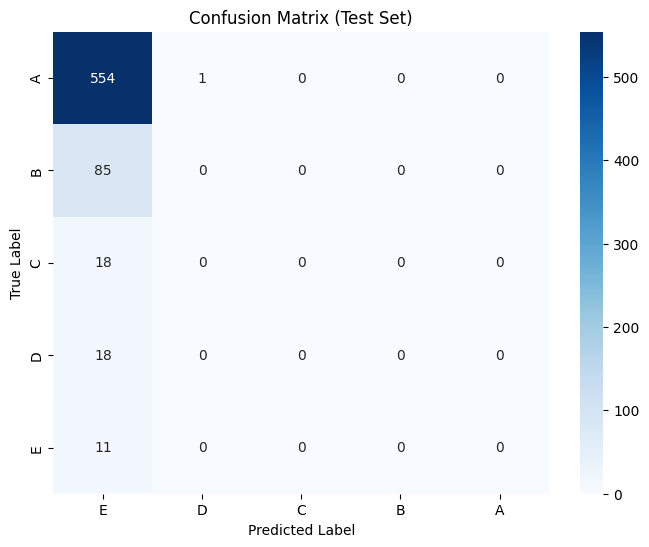

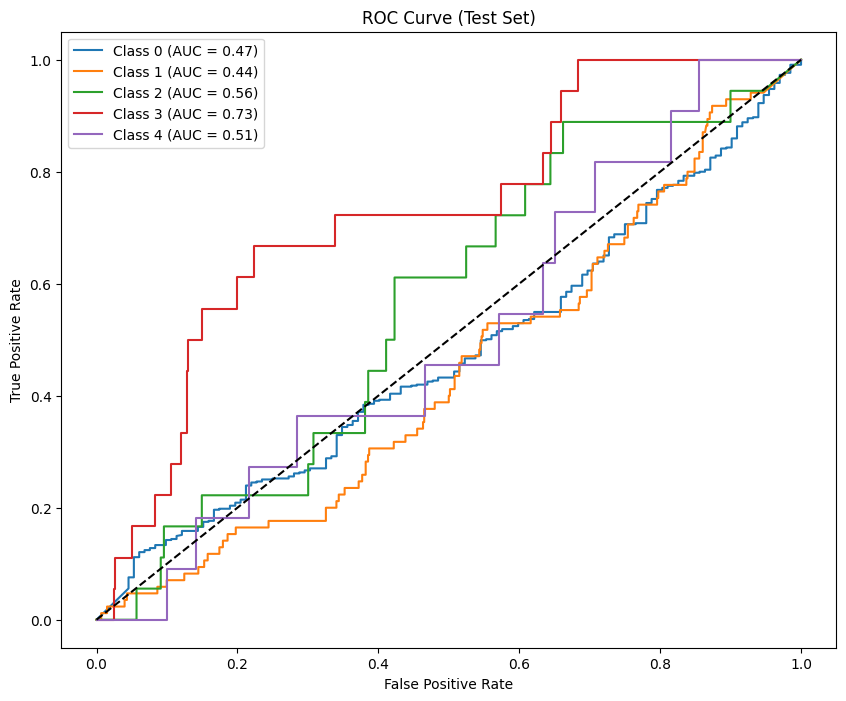

Train F1 (calibrated): [0.85546445 0.55620767 0.09433962 0.53456221 0.35294118] | Test F1 (calibrated): [0.89282836 0.         0.         0.         0.        ]
Train Precision (calibrated): [0.74935678 0.97314376 1.         1.         1.        ] | Test Precision (calibrated): [0.80758017 0.         0.         0.         0.        ]
Train Recall (calibrated): [0.99657827 0.38938053 0.04950495 0.36477987 0.21428571] | Test Recall (calibrated): [0.9981982 0.        0.        0.        0.       ]
Train Accuracy (calibrated): 0.7788551184038784 | Test Accuracy (calibrated): 0.8064046579330422
Train Auc (calibrated): 0.9454259160751095 | Test Auc (calibrated): 0.5412186648983031
Calibrated predictions saved as test_results_calibrate_log_f1_macro_phase4.csv


In [18]:
# Lặp qua các phase
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    process_phase(phase, metric='f1_macro')